# [E-16] 프로젝트: Segmentation map으로 도로 이미지 만들기

<br>

---

---

## **Google Drive 마운팅**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
os.chdir('/content/drive/MyDrive/AIFFEL/Exploration/Ex16/')

## Step 0. 주요 라이브러리 버전 살펴보기
---

In [11]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.6
2.8.2


<br>

## Step 1. 데이터 준비

In [12]:
import os

data_path = os.path.join('/content/drive/MyDrive/AIFFEL/Exploration/Ex16/', 'cityscapes/train/')
print('number of train examples :', len(os.listdir(data_path)))

number of train examples : 1000


이번에는 아래 코드를 이용해 각각의 이미지들이 어떻게 생겼는지 확인해 봅시다. 학습용 데이터셋에서 임의로 6장을 선택하여 시각화합니다.



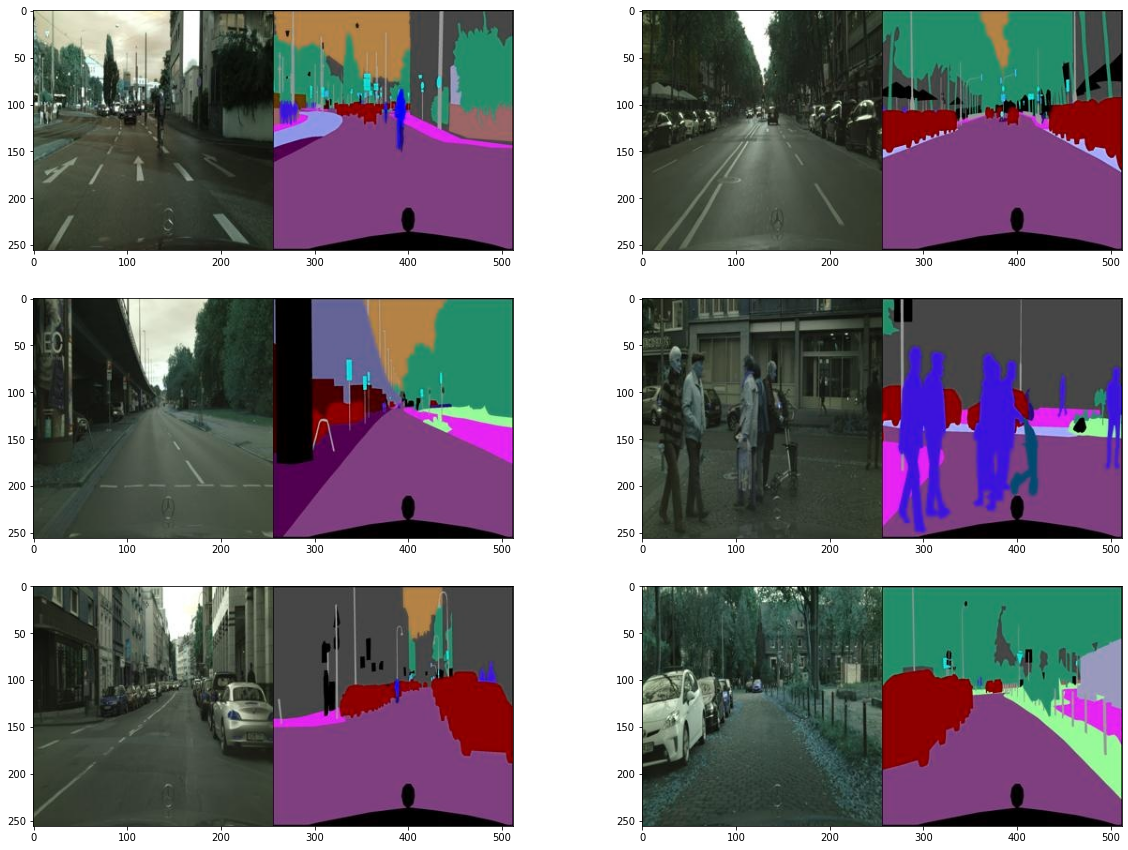

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [14]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)으로 확인되었습니다. 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같네요.

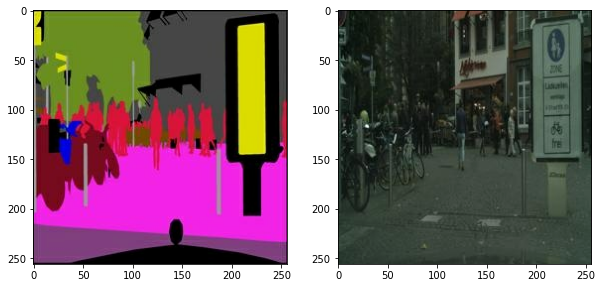

In [15]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

.***1. 데이터에 한가지 이상의 augmentation 방법을 적용하자***<br><br>

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐입니다. 학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보겠습니다.

In [16]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.<br><br>
1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)<br>
2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)<br>
3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)<br>
4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)<br>
5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)<br>

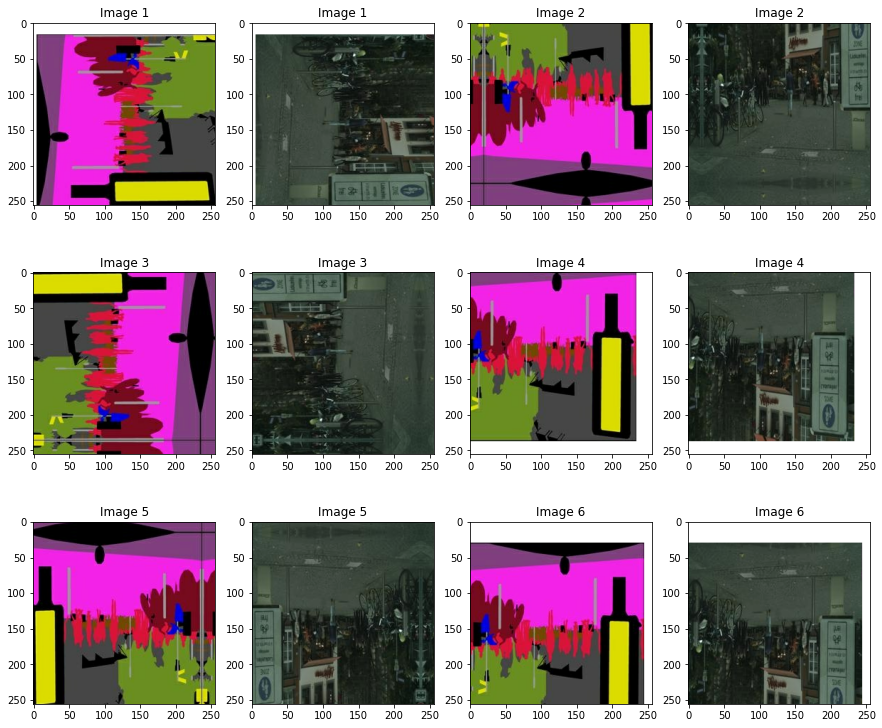

In [17]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보겠습니다.

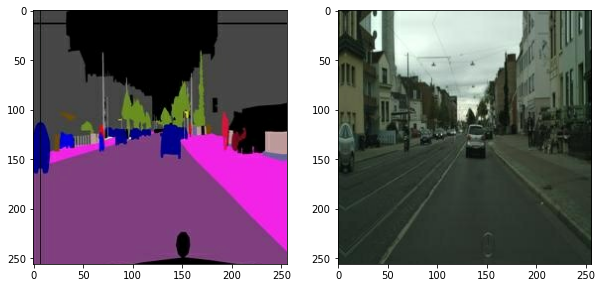

In [18]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br>

## Step 2. Generator 구현하기
### U-Net Generator 구현하기
---

In [19]:
from tensorflow.keras import layers, Input, Model

In [20]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [21]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [22]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [23]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

<br>

## Step 3. Discriminator 구현하기
---

In [24]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했습니다.
사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어봅시다.

In [25]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [26]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

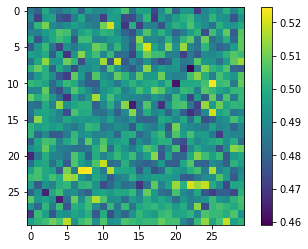

In [27]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

<br>

## Step 4. 학습 및 테스트하기
---

In [28]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [29]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [30]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [31]:
from tqdm import tqdm
import time

In [32]:
EPOCHS = 128

generator = UNetGenerator()
discriminator = Discriminator()

Generator_loss = []
L1_loss = []
Discriminator_loss = []

for epoch in tqdm(range(1, EPOCHS+1)):
    # time.sleep(0.25)
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            Generator_loss.append(g_loss.numpy())
            L1_loss.append(l1_loss.numpy())
            Discriminator_loss.append(d_loss.numpy())
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

  0%|          | 0/128 [00:00<?, ?it/s]

EPOCH[1] - STEP[10]                     
Generator_loss:0.8245                     
L1_loss:0.2844                     
Discriminator_loss:1.3237

EPOCH[1] - STEP[20]                     
Generator_loss:0.7636                     
L1_loss:0.2454                     
Discriminator_loss:1.5064

EPOCH[1] - STEP[30]                     
Generator_loss:0.9490                     
L1_loss:0.2373                     
Discriminator_loss:1.2369

EPOCH[1] - STEP[40]                     
Generator_loss:0.9404                     
L1_loss:0.2078                     
Discriminator_loss:1.2530

EPOCH[1] - STEP[50]                     
Generator_loss:1.0952                     
L1_loss:0.2248                     
Discriminator_loss:1.3445

EPOCH[1] - STEP[60]                     
Generator_loss:1.1232                     
L1_loss:0.1861                     
Discriminator_loss:0.9882

EPOCH[1] - STEP[70]                     
Generator_loss:0.9467                     
L1_loss:0.2190                    

  1%|          | 1/128 [03:34<7:34:19, 214.64s/it]

EPOCH[1] - STEP[250]                     
Generator_loss:0.4509                     
L1_loss:0.2103                     
Discriminator_loss:1.2974

EPOCH[2] - STEP[10]                     
Generator_loss:1.8759                     
L1_loss:0.2092                     
Discriminator_loss:0.4068

EPOCH[2] - STEP[20]                     
Generator_loss:1.5711                     
L1_loss:0.2144                     
Discriminator_loss:0.5753

EPOCH[2] - STEP[30]                     
Generator_loss:1.4847                     
L1_loss:0.1753                     
Discriminator_loss:0.8973

EPOCH[2] - STEP[40]                     
Generator_loss:1.1072                     
L1_loss:0.1854                     
Discriminator_loss:0.9840

EPOCH[2] - STEP[50]                     
Generator_loss:1.1938                     
L1_loss:0.1793                     
Discriminator_loss:0.9500

EPOCH[2] - STEP[60]                     
Generator_loss:2.4541                     
L1_loss:0.1553                   

  2%|▏         | 2/128 [07:10<7:32:21, 215.41s/it]

EPOCH[2] - STEP[250]                     
Generator_loss:2.0227                     
L1_loss:0.1543                     
Discriminator_loss:1.6219

EPOCH[3] - STEP[10]                     
Generator_loss:2.3321                     
L1_loss:0.2046                     
Discriminator_loss:0.7055

EPOCH[3] - STEP[20]                     
Generator_loss:1.3904                     
L1_loss:0.1783                     
Discriminator_loss:0.6522

EPOCH[3] - STEP[30]                     
Generator_loss:0.4987                     
L1_loss:0.1890                     
Discriminator_loss:1.2497

EPOCH[3] - STEP[40]                     
Generator_loss:1.8790                     
L1_loss:0.2395                     
Discriminator_loss:1.2490

EPOCH[3] - STEP[50]                     
Generator_loss:1.1907                     
L1_loss:0.1863                     
Discriminator_loss:0.6049

EPOCH[3] - STEP[60]                     
Generator_loss:1.4623                     
L1_loss:0.1549                   

  2%|▏         | 3/128 [10:44<7:27:31, 214.81s/it]

EPOCH[3] - STEP[250]                     
Generator_loss:3.8419                     
L1_loss:0.1683                     
Discriminator_loss:1.9548

EPOCH[4] - STEP[10]                     
Generator_loss:2.0542                     
L1_loss:0.1644                     
Discriminator_loss:1.4658

EPOCH[4] - STEP[20]                     
Generator_loss:1.6486                     
L1_loss:0.1718                     
Discriminator_loss:0.7061

EPOCH[4] - STEP[30]                     
Generator_loss:0.7097                     
L1_loss:0.2030                     
Discriminator_loss:0.8120

EPOCH[4] - STEP[40]                     
Generator_loss:1.1586                     
L1_loss:0.1801                     
Discriminator_loss:0.5504

EPOCH[4] - STEP[50]                     
Generator_loss:0.8300                     
L1_loss:0.1913                     
Discriminator_loss:0.9605

EPOCH[4] - STEP[60]                     
Generator_loss:1.4425                     
L1_loss:0.1843                   

  3%|▎         | 4/128 [14:50<7:49:35, 227.22s/it]

EPOCH[4] - STEP[250]                     
Generator_loss:1.8409                     
L1_loss:0.1853                     
Discriminator_loss:0.5258

EPOCH[5] - STEP[10]                     
Generator_loss:1.3756                     
L1_loss:0.1880                     
Discriminator_loss:0.5108

EPOCH[5] - STEP[20]                     
Generator_loss:0.7457                     
L1_loss:0.1929                     
Discriminator_loss:1.0633

EPOCH[5] - STEP[30]                     
Generator_loss:1.1355                     
L1_loss:0.1930                     
Discriminator_loss:0.5335

EPOCH[5] - STEP[40]                     
Generator_loss:1.7745                     
L1_loss:0.2212                     
Discriminator_loss:0.3105

EPOCH[5] - STEP[50]                     
Generator_loss:2.0278                     
L1_loss:0.2222                     
Discriminator_loss:0.2906

EPOCH[5] - STEP[60]                     
Generator_loss:2.4001                     
L1_loss:0.2047                   

  4%|▍         | 5/128 [18:57<8:00:16, 234.28s/it]

EPOCH[5] - STEP[250]                     
Generator_loss:1.2818                     
L1_loss:0.2381                     
Discriminator_loss:0.5269

EPOCH[6] - STEP[10]                     
Generator_loss:1.2005                     
L1_loss:0.1521                     
Discriminator_loss:1.2704

EPOCH[6] - STEP[20]                     
Generator_loss:2.7385                     
L1_loss:0.1584                     
Discriminator_loss:1.0758

EPOCH[6] - STEP[30]                     
Generator_loss:0.5620                     
L1_loss:0.1711                     
Discriminator_loss:1.3224

EPOCH[6] - STEP[40]                     
Generator_loss:2.0780                     
L1_loss:0.1889                     
Discriminator_loss:0.2548

EPOCH[6] - STEP[50]                     
Generator_loss:1.6782                     
L1_loss:0.1821                     
Discriminator_loss:0.4514

EPOCH[6] - STEP[60]                     
Generator_loss:0.5225                     
L1_loss:0.1670                   

  5%|▍         | 6/128 [22:57<8:00:06, 236.12s/it]

EPOCH[6] - STEP[250]                     
Generator_loss:1.7534                     
L1_loss:0.1912                     
Discriminator_loss:0.3309

EPOCH[7] - STEP[10]                     
Generator_loss:1.6629                     
L1_loss:0.2216                     
Discriminator_loss:0.2843

EPOCH[7] - STEP[20]                     
Generator_loss:2.0503                     
L1_loss:0.2079                     
Discriminator_loss:0.5818

EPOCH[7] - STEP[30]                     
Generator_loss:2.4139                     
L1_loss:0.2024                     
Discriminator_loss:0.2856

EPOCH[7] - STEP[40]                     
Generator_loss:0.9052                     
L1_loss:0.1654                     
Discriminator_loss:0.6413

EPOCH[7] - STEP[50]                     
Generator_loss:2.3052                     
L1_loss:0.1930                     
Discriminator_loss:0.7923

EPOCH[7] - STEP[60]                     
Generator_loss:1.4832                     
L1_loss:0.2063                   

  5%|▌         | 7/128 [26:55<7:57:30, 236.78s/it]

EPOCH[7] - STEP[250]                     
Generator_loss:1.2888                     
L1_loss:0.1651                     
Discriminator_loss:0.4698

EPOCH[8] - STEP[10]                     
Generator_loss:2.2043                     
L1_loss:0.1772                     
Discriminator_loss:1.9768

EPOCH[8] - STEP[20]                     
Generator_loss:0.8493                     
L1_loss:0.2014                     
Discriminator_loss:0.8182

EPOCH[8] - STEP[30]                     
Generator_loss:0.6763                     
L1_loss:0.2174                     
Discriminator_loss:0.9026

EPOCH[8] - STEP[40]                     
Generator_loss:2.0471                     
L1_loss:0.1926                     
Discriminator_loss:0.2489

EPOCH[8] - STEP[50]                     
Generator_loss:1.2263                     
L1_loss:0.1620                     
Discriminator_loss:0.7290

EPOCH[8] - STEP[60]                     
Generator_loss:1.3793                     
L1_loss:0.1564                   

  6%|▋         | 8/128 [30:30<7:39:47, 229.90s/it]

EPOCH[8] - STEP[250]                     
Generator_loss:1.7598                     
L1_loss:0.1904                     
Discriminator_loss:0.4091

EPOCH[9] - STEP[10]                     
Generator_loss:0.7971                     
L1_loss:0.1936                     
Discriminator_loss:0.7516

EPOCH[9] - STEP[20]                     
Generator_loss:2.1133                     
L1_loss:0.1765                     
Discriminator_loss:0.3664

EPOCH[9] - STEP[30]                     
Generator_loss:0.6784                     
L1_loss:0.1675                     
Discriminator_loss:1.8170

EPOCH[9] - STEP[40]                     
Generator_loss:0.8995                     
L1_loss:0.1928                     
Discriminator_loss:1.0208

EPOCH[9] - STEP[50]                     
Generator_loss:1.2929                     
L1_loss:0.1722                     
Discriminator_loss:1.8725

EPOCH[9] - STEP[60]                     
Generator_loss:1.1204                     
L1_loss:0.1623                   

  7%|▋         | 9/128 [34:00<7:23:34, 223.65s/it]

EPOCH[9] - STEP[250]                     
Generator_loss:1.0261                     
L1_loss:0.1992                     
Discriminator_loss:0.7021

EPOCH[10] - STEP[10]                     
Generator_loss:1.6063                     
L1_loss:0.2022                     
Discriminator_loss:1.6603

EPOCH[10] - STEP[20]                     
Generator_loss:1.1255                     
L1_loss:0.1814                     
Discriminator_loss:0.5746

EPOCH[10] - STEP[30]                     
Generator_loss:1.3811                     
L1_loss:0.1539                     
Discriminator_loss:0.7297

EPOCH[10] - STEP[40]                     
Generator_loss:1.4877                     
L1_loss:0.1954                     
Discriminator_loss:0.5650

EPOCH[10] - STEP[50]                     
Generator_loss:0.9337                     
L1_loss:0.1921                     
Discriminator_loss:0.9569

EPOCH[10] - STEP[60]                     
Generator_loss:1.6385                     
L1_loss:0.1702             

  8%|▊         | 10/128 [37:52<7:24:41, 226.11s/it]

EPOCH[10] - STEP[250]                     
Generator_loss:1.3223                     
L1_loss:0.1546                     
Discriminator_loss:0.6363

EPOCH[11] - STEP[10]                     
Generator_loss:0.3386                     
L1_loss:0.1451                     
Discriminator_loss:1.7837

EPOCH[11] - STEP[20]                     
Generator_loss:0.2845                     
L1_loss:0.1525                     
Discriminator_loss:1.6369

EPOCH[11] - STEP[30]                     
Generator_loss:2.1211                     
L1_loss:0.1584                     
Discriminator_loss:0.4771

EPOCH[11] - STEP[40]                     
Generator_loss:0.9658                     
L1_loss:0.1808                     
Discriminator_loss:0.7822

EPOCH[11] - STEP[50]                     
Generator_loss:1.0145                     
L1_loss:0.2211                     
Discriminator_loss:0.6121

EPOCH[11] - STEP[60]                     
Generator_loss:1.3197                     
L1_loss:0.1883            

  9%|▊         | 11/128 [41:46<7:25:42, 228.56s/it]

EPOCH[11] - STEP[250]                     
Generator_loss:1.4654                     
L1_loss:0.1680                     
Discriminator_loss:0.9209

EPOCH[12] - STEP[10]                     
Generator_loss:2.6683                     
L1_loss:0.2097                     
Discriminator_loss:0.2051

EPOCH[12] - STEP[20]                     
Generator_loss:1.2210                     
L1_loss:0.1767                     
Discriminator_loss:1.0044

EPOCH[12] - STEP[30]                     
Generator_loss:0.5812                     
L1_loss:0.1870                     
Discriminator_loss:1.3853

EPOCH[12] - STEP[40]                     
Generator_loss:0.3402                     
L1_loss:0.1936                     
Discriminator_loss:1.4521

EPOCH[12] - STEP[50]                     
Generator_loss:1.2184                     
L1_loss:0.2365                     
Discriminator_loss:0.5320

EPOCH[12] - STEP[60]                     
Generator_loss:2.0502                     
L1_loss:0.2021            

  9%|▉         | 12/128 [45:42<7:26:05, 230.74s/it]

EPOCH[12] - STEP[250]                     
Generator_loss:0.7089                     
L1_loss:0.2045                     
Discriminator_loss:0.8317

EPOCH[13] - STEP[10]                     
Generator_loss:1.4485                     
L1_loss:0.1672                     
Discriminator_loss:0.5346

EPOCH[13] - STEP[20]                     
Generator_loss:1.3337                     
L1_loss:0.1734                     
Discriminator_loss:2.2660

EPOCH[13] - STEP[30]                     
Generator_loss:1.1600                     
L1_loss:0.1746                     
Discriminator_loss:0.4824

EPOCH[13] - STEP[40]                     
Generator_loss:1.0622                     
L1_loss:0.1741                     
Discriminator_loss:0.6744

EPOCH[13] - STEP[50]                     
Generator_loss:1.3013                     
L1_loss:0.2161                     
Discriminator_loss:0.4035

EPOCH[13] - STEP[60]                     
Generator_loss:0.5573                     
L1_loss:0.1746            

 10%|█         | 13/128 [49:34<7:23:15, 231.27s/it]

EPOCH[13] - STEP[250]                     
Generator_loss:1.3418                     
L1_loss:0.1998                     
Discriminator_loss:0.4288

EPOCH[14] - STEP[10]                     
Generator_loss:1.7075                     
L1_loss:0.1449                     
Discriminator_loss:1.3443

EPOCH[14] - STEP[20]                     
Generator_loss:0.4206                     
L1_loss:0.1808                     
Discriminator_loss:2.0453

EPOCH[14] - STEP[30]                     
Generator_loss:1.7215                     
L1_loss:0.2162                     
Discriminator_loss:0.2564

EPOCH[14] - STEP[40]                     
Generator_loss:1.3996                     
L1_loss:0.1709                     
Discriminator_loss:0.9591

EPOCH[14] - STEP[50]                     
Generator_loss:0.7081                     
L1_loss:0.1722                     
Discriminator_loss:1.0045

EPOCH[14] - STEP[60]                     
Generator_loss:1.8980                     
L1_loss:0.1652            

 11%|█         | 14/128 [53:13<7:12:11, 227.47s/it]

EPOCH[14] - STEP[250]                     
Generator_loss:1.1315                     
L1_loss:0.1652                     
Discriminator_loss:2.0513

EPOCH[15] - STEP[10]                     
Generator_loss:2.1752                     
L1_loss:0.1963                     
Discriminator_loss:0.6526

EPOCH[15] - STEP[20]                     
Generator_loss:0.3999                     
L1_loss:0.1613                     
Discriminator_loss:1.4419

EPOCH[15] - STEP[30]                     
Generator_loss:2.1775                     
L1_loss:0.1914                     
Discriminator_loss:0.2377

EPOCH[15] - STEP[40]                     
Generator_loss:2.4666                     
L1_loss:0.1581                     
Discriminator_loss:0.8932

EPOCH[15] - STEP[50]                     
Generator_loss:1.5070                     
L1_loss:0.1986                     
Discriminator_loss:0.6081

EPOCH[15] - STEP[60]                     
Generator_loss:1.3299                     
L1_loss:0.2141            

 12%|█▏        | 15/128 [56:51<7:03:02, 224.63s/it]

EPOCH[15] - STEP[250]                     
Generator_loss:2.5760                     
L1_loss:0.1810                     
Discriminator_loss:0.7719

EPOCH[16] - STEP[10]                     
Generator_loss:0.8212                     
L1_loss:0.1413                     
Discriminator_loss:1.4937

EPOCH[16] - STEP[20]                     
Generator_loss:2.2753                     
L1_loss:0.1730                     
Discriminator_loss:0.7807

EPOCH[16] - STEP[30]                     
Generator_loss:0.7088                     
L1_loss:0.1931                     
Discriminator_loss:1.1333

EPOCH[16] - STEP[40]                     
Generator_loss:0.4998                     
L1_loss:0.1944                     
Discriminator_loss:1.0726

EPOCH[16] - STEP[50]                     
Generator_loss:1.5013                     
L1_loss:0.1760                     
Discriminator_loss:0.7587

EPOCH[16] - STEP[60]                     
Generator_loss:1.4013                     
L1_loss:0.1778            

 12%|█▎        | 16/128 [1:00:31<6:56:41, 223.23s/it]

EPOCH[16] - STEP[250]                     
Generator_loss:0.6559                     
L1_loss:0.1753                     
Discriminator_loss:0.9372

EPOCH[17] - STEP[10]                     
Generator_loss:3.0194                     
L1_loss:0.1775                     
Discriminator_loss:1.2044

EPOCH[17] - STEP[20]                     
Generator_loss:1.7891                     
L1_loss:0.1685                     
Discriminator_loss:0.5064

EPOCH[17] - STEP[30]                     
Generator_loss:1.8342                     
L1_loss:0.2073                     
Discriminator_loss:0.2948

EPOCH[17] - STEP[40]                     
Generator_loss:2.0382                     
L1_loss:0.1347                     
Discriminator_loss:2.0244

EPOCH[17] - STEP[50]                     
Generator_loss:2.0579                     
L1_loss:0.1606                     
Discriminator_loss:0.5827

EPOCH[17] - STEP[60]                     
Generator_loss:0.7254                     
L1_loss:0.2024            

 13%|█▎        | 17/128 [1:04:10<6:50:40, 221.99s/it]

EPOCH[17] - STEP[250]                     
Generator_loss:1.7254                     
L1_loss:0.1780                     
Discriminator_loss:2.0469

EPOCH[18] - STEP[10]                     
Generator_loss:1.1748                     
L1_loss:0.1662                     
Discriminator_loss:0.5787

EPOCH[18] - STEP[20]                     
Generator_loss:1.5946                     
L1_loss:0.1588                     
Discriminator_loss:0.9753

EPOCH[18] - STEP[30]                     
Generator_loss:0.8225                     
L1_loss:0.1996                     
Discriminator_loss:0.6883

EPOCH[18] - STEP[40]                     
Generator_loss:0.9296                     
L1_loss:0.1657                     
Discriminator_loss:1.5105

EPOCH[18] - STEP[50]                     
Generator_loss:0.4800                     
L1_loss:0.1641                     
Discriminator_loss:1.4607

EPOCH[18] - STEP[60]                     
Generator_loss:2.7757                     
L1_loss:0.1523            

 14%|█▍        | 18/128 [1:07:36<6:38:20, 217.27s/it]

EPOCH[18] - STEP[250]                     
Generator_loss:1.8696                     
L1_loss:0.1820                     
Discriminator_loss:1.1804

EPOCH[19] - STEP[10]                     
Generator_loss:1.8703                     
L1_loss:0.1580                     
Discriminator_loss:1.5582

EPOCH[19] - STEP[20]                     
Generator_loss:1.2547                     
L1_loss:0.1961                     
Discriminator_loss:0.5837

EPOCH[19] - STEP[30]                     
Generator_loss:1.1055                     
L1_loss:0.1609                     
Discriminator_loss:0.7290

EPOCH[19] - STEP[40]                     
Generator_loss:2.4506                     
L1_loss:0.1720                     
Discriminator_loss:1.3079

EPOCH[19] - STEP[50]                     
Generator_loss:1.2054                     
L1_loss:0.1925                     
Discriminator_loss:0.4987

EPOCH[19] - STEP[60]                     
Generator_loss:1.7436                     
L1_loss:0.1750            

 15%|█▍        | 19/128 [1:11:02<6:28:30, 213.86s/it]

EPOCH[19] - STEP[250]                     
Generator_loss:1.3264                     
L1_loss:0.1739                     
Discriminator_loss:0.5741

EPOCH[20] - STEP[10]                     
Generator_loss:2.1413                     
L1_loss:0.1996                     
Discriminator_loss:0.5610

EPOCH[20] - STEP[20]                     
Generator_loss:0.4788                     
L1_loss:0.1723                     
Discriminator_loss:1.2024

EPOCH[20] - STEP[30]                     
Generator_loss:1.5171                     
L1_loss:0.1770                     
Discriminator_loss:1.8965

EPOCH[20] - STEP[40]                     
Generator_loss:1.2588                     
L1_loss:0.1927                     
Discriminator_loss:0.6915

EPOCH[20] - STEP[50]                     
Generator_loss:1.1907                     
L1_loss:0.1968                     
Discriminator_loss:0.5282

EPOCH[20] - STEP[60]                     
Generator_loss:1.8423                     
L1_loss:0.1549            

 16%|█▌        | 20/128 [1:14:29<6:21:07, 211.73s/it]

EPOCH[20] - STEP[250]                     
Generator_loss:1.0081                     
L1_loss:0.1840                     
Discriminator_loss:0.5813

EPOCH[21] - STEP[10]                     
Generator_loss:0.5918                     
L1_loss:0.1976                     
Discriminator_loss:0.9246

EPOCH[21] - STEP[20]                     
Generator_loss:1.3480                     
L1_loss:0.1756                     
Discriminator_loss:0.5262

EPOCH[21] - STEP[30]                     
Generator_loss:0.9400                     
L1_loss:0.1707                     
Discriminator_loss:1.2413

EPOCH[21] - STEP[40]                     
Generator_loss:0.9925                     
L1_loss:0.1600                     
Discriminator_loss:0.9084

EPOCH[21] - STEP[50]                     
Generator_loss:2.6186                     
L1_loss:0.1855                     
Discriminator_loss:0.3787

EPOCH[21] - STEP[60]                     
Generator_loss:1.5775                     
L1_loss:0.1699            

 16%|█▋        | 21/128 [1:17:55<6:14:20, 209.91s/it]

EPOCH[21] - STEP[250]                     
Generator_loss:2.2531                     
L1_loss:0.1836                     
Discriminator_loss:1.2096

EPOCH[22] - STEP[10]                     
Generator_loss:2.1540                     
L1_loss:0.1981                     
Discriminator_loss:1.2940

EPOCH[22] - STEP[20]                     
Generator_loss:2.4129                     
L1_loss:0.1980                     
Discriminator_loss:0.7982

EPOCH[22] - STEP[30]                     
Generator_loss:0.7076                     
L1_loss:0.1693                     
Discriminator_loss:1.6258

EPOCH[22] - STEP[40]                     
Generator_loss:0.7263                     
L1_loss:0.1860                     
Discriminator_loss:1.2679

EPOCH[22] - STEP[50]                     
Generator_loss:1.0438                     
L1_loss:0.1824                     
Discriminator_loss:0.7994

EPOCH[22] - STEP[60]                     
Generator_loss:2.0781                     
L1_loss:0.1865            

 17%|█▋        | 22/128 [1:21:19<6:08:09, 208.40s/it]

EPOCH[22] - STEP[250]                     
Generator_loss:1.6079                     
L1_loss:0.1658                     
Discriminator_loss:0.6425

EPOCH[23] - STEP[10]                     
Generator_loss:1.0095                     
L1_loss:0.1769                     
Discriminator_loss:0.7028

EPOCH[23] - STEP[20]                     
Generator_loss:1.6768                     
L1_loss:0.1859                     
Discriminator_loss:0.7959

EPOCH[23] - STEP[30]                     
Generator_loss:1.8769                     
L1_loss:0.1891                     
Discriminator_loss:0.3102

EPOCH[23] - STEP[40]                     
Generator_loss:1.3157                     
L1_loss:0.1594                     
Discriminator_loss:0.5479

EPOCH[23] - STEP[50]                     
Generator_loss:1.0939                     
L1_loss:0.1579                     
Discriminator_loss:0.5592

EPOCH[23] - STEP[60]                     
Generator_loss:1.5931                     
L1_loss:0.1659            

 18%|█▊        | 23/128 [1:24:44<6:02:31, 207.16s/it]

EPOCH[23] - STEP[250]                     
Generator_loss:0.6471                     
L1_loss:0.1636                     
Discriminator_loss:1.3244

EPOCH[24] - STEP[10]                     
Generator_loss:1.5384                     
L1_loss:0.1615                     
Discriminator_loss:1.6287

EPOCH[24] - STEP[20]                     
Generator_loss:1.5055                     
L1_loss:0.1677                     
Discriminator_loss:0.3709

EPOCH[24] - STEP[30]                     
Generator_loss:1.6057                     
L1_loss:0.1631                     
Discriminator_loss:0.5424

EPOCH[24] - STEP[40]                     
Generator_loss:1.5723                     
L1_loss:0.1704                     
Discriminator_loss:0.7749

EPOCH[24] - STEP[50]                     
Generator_loss:1.4596                     
L1_loss:0.1623                     
Discriminator_loss:0.6894

EPOCH[24] - STEP[60]                     
Generator_loss:1.0251                     
L1_loss:0.1718            

 19%|█▉        | 24/128 [1:28:08<5:57:38, 206.33s/it]

EPOCH[24] - STEP[250]                     
Generator_loss:1.3694                     
L1_loss:0.1971                     
Discriminator_loss:0.5424

EPOCH[25] - STEP[10]                     
Generator_loss:2.0413                     
L1_loss:0.2136                     
Discriminator_loss:0.7813

EPOCH[25] - STEP[20]                     
Generator_loss:1.4792                     
L1_loss:0.2015                     
Discriminator_loss:0.4540

EPOCH[25] - STEP[30]                     
Generator_loss:0.8358                     
L1_loss:0.1908                     
Discriminator_loss:1.0039

EPOCH[25] - STEP[40]                     
Generator_loss:1.2171                     
L1_loss:0.2054                     
Discriminator_loss:0.4251

EPOCH[25] - STEP[50]                     
Generator_loss:0.2308                     
L1_loss:0.1868                     
Discriminator_loss:1.8818

EPOCH[25] - STEP[60]                     
Generator_loss:0.5140                     
L1_loss:0.1867            

 20%|█▉        | 25/128 [1:31:42<5:57:57, 208.52s/it]

EPOCH[25] - STEP[250]                     
Generator_loss:2.4018                     
L1_loss:0.1740                     
Discriminator_loss:1.3325

EPOCH[26] - STEP[10]                     
Generator_loss:0.3879                     
L1_loss:0.1752                     
Discriminator_loss:1.3968

EPOCH[26] - STEP[20]                     
Generator_loss:0.9148                     
L1_loss:0.2024                     
Discriminator_loss:0.6145

EPOCH[26] - STEP[30]                     
Generator_loss:1.7956                     
L1_loss:0.1957                     
Discriminator_loss:0.2728

EPOCH[26] - STEP[40]                     
Generator_loss:0.3756                     
L1_loss:0.1703                     
Discriminator_loss:1.3640

EPOCH[26] - STEP[50]                     
Generator_loss:2.0865                     
L1_loss:0.1833                     
Discriminator_loss:0.4113

EPOCH[26] - STEP[60]                     
Generator_loss:2.2946                     
L1_loss:0.1618            

 20%|██        | 26/128 [1:35:26<6:02:39, 213.33s/it]

EPOCH[26] - STEP[250]                     
Generator_loss:1.9135                     
L1_loss:0.1772                     
Discriminator_loss:0.8549

EPOCH[27] - STEP[10]                     
Generator_loss:0.9666                     
L1_loss:0.1661                     
Discriminator_loss:1.7123

EPOCH[27] - STEP[20]                     
Generator_loss:1.2312                     
L1_loss:0.1996                     
Discriminator_loss:0.5416

EPOCH[27] - STEP[30]                     
Generator_loss:1.5318                     
L1_loss:0.1973                     
Discriminator_loss:0.6379

EPOCH[27] - STEP[40]                     
Generator_loss:2.6092                     
L1_loss:0.1674                     
Discriminator_loss:1.4785

EPOCH[27] - STEP[50]                     
Generator_loss:1.0752                     
L1_loss:0.1862                     
Discriminator_loss:2.0434

EPOCH[27] - STEP[60]                     
Generator_loss:1.7429                     
L1_loss:0.1526            

 21%|██        | 27/128 [1:39:20<6:09:13, 219.34s/it]

EPOCH[27] - STEP[250]                     
Generator_loss:1.7626                     
L1_loss:0.1792                     
Discriminator_loss:0.9978

EPOCH[28] - STEP[10]                     
Generator_loss:1.5487                     
L1_loss:0.2001                     
Discriminator_loss:0.6971

EPOCH[28] - STEP[20]                     
Generator_loss:1.8197                     
L1_loss:0.1665                     
Discriminator_loss:1.0165

EPOCH[28] - STEP[30]                     
Generator_loss:1.8123                     
L1_loss:0.1939                     
Discriminator_loss:0.4054

EPOCH[28] - STEP[40]                     
Generator_loss:1.1686                     
L1_loss:0.1823                     
Discriminator_loss:1.6511

EPOCH[28] - STEP[50]                     
Generator_loss:0.2922                     
L1_loss:0.1947                     
Discriminator_loss:1.6887

EPOCH[28] - STEP[60]                     
Generator_loss:0.7601                     
L1_loss:0.1849            

 22%|██▏       | 28/128 [1:43:09<6:10:27, 222.28s/it]

EPOCH[28] - STEP[250]                     
Generator_loss:0.7785                     
L1_loss:0.1793                     
Discriminator_loss:1.0598

EPOCH[29] - STEP[10]                     
Generator_loss:1.7604                     
L1_loss:0.1644                     
Discriminator_loss:0.7975

EPOCH[29] - STEP[20]                     
Generator_loss:1.3924                     
L1_loss:0.2221                     
Discriminator_loss:0.6118

EPOCH[29] - STEP[30]                     
Generator_loss:2.8656                     
L1_loss:0.1558                     
Discriminator_loss:2.8964

EPOCH[29] - STEP[40]                     
Generator_loss:0.6485                     
L1_loss:0.1969                     
Discriminator_loss:0.9611

EPOCH[29] - STEP[50]                     
Generator_loss:1.0879                     
L1_loss:0.1423                     
Discriminator_loss:1.2539

EPOCH[29] - STEP[60]                     
Generator_loss:1.6562                     
L1_loss:0.1609            

 23%|██▎       | 29/128 [1:46:42<6:02:26, 219.66s/it]

EPOCH[29] - STEP[250]                     
Generator_loss:1.7868                     
L1_loss:0.1913                     
Discriminator_loss:0.7454

EPOCH[30] - STEP[10]                     
Generator_loss:2.4338                     
L1_loss:0.1681                     
Discriminator_loss:0.4168

EPOCH[30] - STEP[20]                     
Generator_loss:1.5504                     
L1_loss:0.1527                     
Discriminator_loss:1.2548

EPOCH[30] - STEP[30]                     
Generator_loss:2.1573                     
L1_loss:0.1417                     
Discriminator_loss:0.9194

EPOCH[30] - STEP[40]                     
Generator_loss:1.8896                     
L1_loss:0.2063                     
Discriminator_loss:0.3072

EPOCH[30] - STEP[50]                     
Generator_loss:0.6133                     
L1_loss:0.1870                     
Discriminator_loss:0.9544

EPOCH[30] - STEP[60]                     
Generator_loss:0.9705                     
L1_loss:0.1674            

 23%|██▎       | 30/128 [1:50:09<5:52:20, 215.72s/it]

EPOCH[30] - STEP[250]                     
Generator_loss:0.6670                     
L1_loss:0.1836                     
Discriminator_loss:1.7546

EPOCH[31] - STEP[10]                     
Generator_loss:0.6031                     
L1_loss:0.1593                     
Discriminator_loss:1.6525

EPOCH[31] - STEP[20]                     
Generator_loss:1.4885                     
L1_loss:0.2139                     
Discriminator_loss:0.3077

EPOCH[31] - STEP[30]                     
Generator_loss:1.1198                     
L1_loss:0.1765                     
Discriminator_loss:0.6616

EPOCH[31] - STEP[40]                     
Generator_loss:0.8820                     
L1_loss:0.1859                     
Discriminator_loss:0.6379

EPOCH[31] - STEP[50]                     
Generator_loss:0.9679                     
L1_loss:0.1415                     
Discriminator_loss:2.4508

EPOCH[31] - STEP[60]                     
Generator_loss:1.2219                     
L1_loss:0.1611            

 24%|██▍       | 31/128 [1:54:03<5:57:38, 221.22s/it]

EPOCH[31] - STEP[250]                     
Generator_loss:1.0772                     
L1_loss:0.1803                     
Discriminator_loss:0.6262

EPOCH[32] - STEP[10]                     
Generator_loss:1.9968                     
L1_loss:0.1658                     
Discriminator_loss:1.7199

EPOCH[32] - STEP[20]                     
Generator_loss:1.0739                     
L1_loss:0.1693                     
Discriminator_loss:1.0012

EPOCH[32] - STEP[30]                     
Generator_loss:3.2904                     
L1_loss:0.1610                     
Discriminator_loss:1.8256

EPOCH[32] - STEP[40]                     
Generator_loss:2.2913                     
L1_loss:0.1696                     
Discriminator_loss:1.2801

EPOCH[32] - STEP[50]                     
Generator_loss:1.5868                     
L1_loss:0.2191                     
Discriminator_loss:0.4143

EPOCH[32] - STEP[60]                     
Generator_loss:2.2338                     
L1_loss:0.2006            

 25%|██▌       | 32/128 [1:58:08<6:05:16, 228.30s/it]

EPOCH[32] - STEP[250]                     
Generator_loss:0.5245                     
L1_loss:0.1738                     
Discriminator_loss:1.0912

EPOCH[33] - STEP[10]                     
Generator_loss:0.6970                     
L1_loss:0.1984                     
Discriminator_loss:0.7772

EPOCH[33] - STEP[20]                     
Generator_loss:1.0849                     
L1_loss:0.2201                     
Discriminator_loss:0.6754

EPOCH[33] - STEP[30]                     
Generator_loss:1.0359                     
L1_loss:0.1543                     
Discriminator_loss:0.8656

EPOCH[33] - STEP[40]                     
Generator_loss:1.0648                     
L1_loss:0.1501                     
Discriminator_loss:1.2003

EPOCH[33] - STEP[50]                     
Generator_loss:3.2021                     
L1_loss:0.1827                     
Discriminator_loss:1.2653

EPOCH[33] - STEP[60]                     
Generator_loss:0.9333                     
L1_loss:0.1841            

 26%|██▌       | 33/128 [2:02:04<6:05:18, 230.72s/it]

EPOCH[33] - STEP[250]                     
Generator_loss:1.3562                     
L1_loss:0.2065                     
Discriminator_loss:0.3691

EPOCH[34] - STEP[10]                     
Generator_loss:0.5946                     
L1_loss:0.1881                     
Discriminator_loss:0.9111

EPOCH[34] - STEP[20]                     
Generator_loss:0.8914                     
L1_loss:0.1664                     
Discriminator_loss:1.5504

EPOCH[34] - STEP[30]                     
Generator_loss:1.3986                     
L1_loss:0.2220                     
Discriminator_loss:0.3295

EPOCH[34] - STEP[40]                     
Generator_loss:1.2015                     
L1_loss:0.1638                     
Discriminator_loss:0.4834

EPOCH[34] - STEP[50]                     
Generator_loss:1.7228                     
L1_loss:0.1600                     
Discriminator_loss:0.3543

EPOCH[34] - STEP[60]                     
Generator_loss:1.2707                     
L1_loss:0.1639            

 27%|██▋       | 34/128 [2:05:50<5:59:03, 229.18s/it]

EPOCH[34] - STEP[250]                     
Generator_loss:3.3369                     
L1_loss:0.1679                     
Discriminator_loss:0.8555

EPOCH[35] - STEP[10]                     
Generator_loss:1.2391                     
L1_loss:0.1747                     
Discriminator_loss:0.6106

EPOCH[35] - STEP[20]                     
Generator_loss:0.6520                     
L1_loss:0.1710                     
Discriminator_loss:1.7448

EPOCH[35] - STEP[30]                     
Generator_loss:1.1709                     
L1_loss:0.1702                     
Discriminator_loss:0.8368

EPOCH[35] - STEP[40]                     
Generator_loss:1.3703                     
L1_loss:0.1659                     
Discriminator_loss:1.8005

EPOCH[35] - STEP[50]                     
Generator_loss:0.5460                     
L1_loss:0.1513                     
Discriminator_loss:1.2167

EPOCH[35] - STEP[60]                     
Generator_loss:1.0128                     
L1_loss:0.1793            

 27%|██▋       | 35/128 [2:09:33<5:52:36, 227.49s/it]

EPOCH[35] - STEP[250]                     
Generator_loss:1.7845                     
L1_loss:0.1549                     
Discriminator_loss:0.8188

EPOCH[36] - STEP[10]                     
Generator_loss:1.5726                     
L1_loss:0.1830                     
Discriminator_loss:0.4991

EPOCH[36] - STEP[20]                     
Generator_loss:1.4857                     
L1_loss:0.1566                     
Discriminator_loss:0.5672

EPOCH[36] - STEP[30]                     
Generator_loss:0.9004                     
L1_loss:0.1752                     
Discriminator_loss:1.1843

EPOCH[36] - STEP[40]                     
Generator_loss:1.5205                     
L1_loss:0.2056                     
Discriminator_loss:0.3103

EPOCH[36] - STEP[50]                     
Generator_loss:0.7027                     
L1_loss:0.1871                     
Discriminator_loss:1.0264

EPOCH[36] - STEP[60]                     
Generator_loss:2.7563                     
L1_loss:0.1600            

 28%|██▊       | 36/128 [2:13:16<5:46:52, 226.22s/it]

EPOCH[36] - STEP[250]                     
Generator_loss:1.8031                     
L1_loss:0.1709                     
Discriminator_loss:1.6283

EPOCH[37] - STEP[10]                     
Generator_loss:1.9615                     
L1_loss:0.1643                     
Discriminator_loss:1.0938

EPOCH[37] - STEP[20]                     
Generator_loss:1.5744                     
L1_loss:0.1657                     
Discriminator_loss:0.5327

EPOCH[37] - STEP[30]                     
Generator_loss:0.9299                     
L1_loss:0.1538                     
Discriminator_loss:0.7917

EPOCH[37] - STEP[40]                     
Generator_loss:1.3441                     
L1_loss:0.1552                     
Discriminator_loss:1.8253

EPOCH[37] - STEP[50]                     
Generator_loss:0.8120                     
L1_loss:0.1664                     
Discriminator_loss:1.0608

EPOCH[37] - STEP[60]                     
Generator_loss:1.0698                     
L1_loss:0.1779            

 29%|██▉       | 37/128 [2:16:58<5:40:59, 224.83s/it]

EPOCH[37] - STEP[250]                     
Generator_loss:1.8250                     
L1_loss:0.1690                     
Discriminator_loss:1.5101

EPOCH[38] - STEP[10]                     
Generator_loss:0.9439                     
L1_loss:0.1317                     
Discriminator_loss:1.7440

EPOCH[38] - STEP[20]                     
Generator_loss:0.7326                     
L1_loss:0.2050                     
Discriminator_loss:0.8402

EPOCH[38] - STEP[30]                     
Generator_loss:1.6674                     
L1_loss:0.1867                     
Discriminator_loss:0.8777

EPOCH[38] - STEP[40]                     
Generator_loss:1.5963                     
L1_loss:0.1654                     
Discriminator_loss:1.3171

EPOCH[38] - STEP[50]                     
Generator_loss:1.6354                     
L1_loss:0.1546                     
Discriminator_loss:0.5060

EPOCH[38] - STEP[60]                     
Generator_loss:0.7478                     
L1_loss:0.1756            

 30%|██▉       | 38/128 [2:20:24<5:28:52, 219.25s/it]

EPOCH[38] - STEP[250]                     
Generator_loss:0.8360                     
L1_loss:0.1773                     
Discriminator_loss:0.9956

EPOCH[39] - STEP[10]                     
Generator_loss:1.1275                     
L1_loss:0.1680                     
Discriminator_loss:0.5063

EPOCH[39] - STEP[20]                     
Generator_loss:0.9767                     
L1_loss:0.1778                     
Discriminator_loss:0.6229

EPOCH[39] - STEP[30]                     
Generator_loss:0.9375                     
L1_loss:0.1655                     
Discriminator_loss:1.0279

EPOCH[39] - STEP[40]                     
Generator_loss:0.6366                     
L1_loss:0.1594                     
Discriminator_loss:1.0810

EPOCH[39] - STEP[50]                     
Generator_loss:2.0944                     
L1_loss:0.1790                     
Discriminator_loss:0.6954

EPOCH[39] - STEP[60]                     
Generator_loss:1.0569                     
L1_loss:0.1701            

 30%|███       | 39/128 [2:24:01<5:23:56, 218.38s/it]

EPOCH[39] - STEP[250]                     
Generator_loss:2.1454                     
L1_loss:0.1726                     
Discriminator_loss:0.8314

EPOCH[40] - STEP[10]                     
Generator_loss:1.6855                     
L1_loss:0.1758                     
Discriminator_loss:0.7469

EPOCH[40] - STEP[20]                     
Generator_loss:0.7758                     
L1_loss:0.2045                     
Discriminator_loss:0.9603

EPOCH[40] - STEP[30]                     
Generator_loss:1.1089                     
L1_loss:0.1455                     
Discriminator_loss:1.2173

EPOCH[40] - STEP[40]                     
Generator_loss:2.1190                     
L1_loss:0.2132                     
Discriminator_loss:0.2319

EPOCH[40] - STEP[50]                     
Generator_loss:1.7494                     
L1_loss:0.1616                     
Discriminator_loss:1.2338

EPOCH[40] - STEP[60]                     
Generator_loss:1.2012                     
L1_loss:0.1810            

 31%|███▏      | 40/128 [2:27:51<5:25:42, 222.08s/it]

EPOCH[40] - STEP[250]                     
Generator_loss:1.8883                     
L1_loss:0.1344                     
Discriminator_loss:2.0129

EPOCH[41] - STEP[10]                     
Generator_loss:1.3850                     
L1_loss:0.1704                     
Discriminator_loss:0.6009

EPOCH[41] - STEP[20]                     
Generator_loss:1.2034                     
L1_loss:0.1742                     
Discriminator_loss:0.4669

EPOCH[41] - STEP[30]                     
Generator_loss:1.7117                     
L1_loss:0.1914                     
Discriminator_loss:0.2679

EPOCH[41] - STEP[40]                     
Generator_loss:1.5040                     
L1_loss:0.1729                     
Discriminator_loss:0.6137

EPOCH[41] - STEP[50]                     
Generator_loss:1.2861                     
L1_loss:0.2013                     
Discriminator_loss:0.4088

EPOCH[41] - STEP[60]                     
Generator_loss:2.2655                     
L1_loss:0.1950            

 32%|███▏      | 41/128 [2:31:34<5:22:22, 222.32s/it]

EPOCH[41] - STEP[250]                     
Generator_loss:0.8233                     
L1_loss:0.1646                     
Discriminator_loss:0.8727

EPOCH[42] - STEP[10]                     
Generator_loss:1.0611                     
L1_loss:0.1555                     
Discriminator_loss:1.7183

EPOCH[42] - STEP[20]                     
Generator_loss:1.4353                     
L1_loss:0.1929                     
Discriminator_loss:0.3769

EPOCH[42] - STEP[30]                     
Generator_loss:1.5465                     
L1_loss:0.1771                     
Discriminator_loss:0.3940

EPOCH[42] - STEP[40]                     
Generator_loss:1.6511                     
L1_loss:0.1879                     
Discriminator_loss:0.6842

EPOCH[42] - STEP[50]                     
Generator_loss:2.1702                     
L1_loss:0.1644                     
Discriminator_loss:0.8713

EPOCH[42] - STEP[60]                     
Generator_loss:1.5911                     
L1_loss:0.1907            

 33%|███▎      | 42/128 [2:35:16<5:18:17, 222.06s/it]

EPOCH[42] - STEP[250]                     
Generator_loss:0.4798                     
L1_loss:0.1898                     
Discriminator_loss:1.2663

EPOCH[43] - STEP[10]                     
Generator_loss:1.7589                     
L1_loss:0.1426                     
Discriminator_loss:1.2095

EPOCH[43] - STEP[20]                     
Generator_loss:1.7391                     
L1_loss:0.1798                     
Discriminator_loss:0.2896

EPOCH[43] - STEP[30]                     
Generator_loss:1.4569                     
L1_loss:0.2254                     
Discriminator_loss:0.3351

EPOCH[43] - STEP[40]                     
Generator_loss:1.0906                     
L1_loss:0.1850                     
Discriminator_loss:0.5958

EPOCH[43] - STEP[50]                     
Generator_loss:1.6160                     
L1_loss:0.1435                     
Discriminator_loss:0.7846

EPOCH[43] - STEP[60]                     
Generator_loss:1.9371                     
L1_loss:0.1787            

 34%|███▎      | 43/128 [2:38:58<5:14:39, 222.11s/it]

EPOCH[43] - STEP[250]                     
Generator_loss:2.3433                     
L1_loss:0.1931                     
Discriminator_loss:0.4480

EPOCH[44] - STEP[10]                     
Generator_loss:1.4976                     
L1_loss:0.1696                     
Discriminator_loss:1.9579

EPOCH[44] - STEP[20]                     
Generator_loss:1.2149                     
L1_loss:0.1563                     
Discriminator_loss:0.9602

EPOCH[44] - STEP[30]                     
Generator_loss:1.7360                     
L1_loss:0.2180                     
Discriminator_loss:0.2480

EPOCH[44] - STEP[40]                     
Generator_loss:2.1212                     
L1_loss:0.1515                     
Discriminator_loss:1.3039

EPOCH[44] - STEP[50]                     
Generator_loss:1.9028                     
L1_loss:0.1517                     
Discriminator_loss:2.4138

EPOCH[44] - STEP[60]                     
Generator_loss:1.0232                     
L1_loss:0.2243            

 34%|███▍      | 44/128 [2:42:35<5:08:52, 220.62s/it]

EPOCH[44] - STEP[250]                     
Generator_loss:2.6026                     
L1_loss:0.1626                     
Discriminator_loss:1.0792

EPOCH[45] - STEP[10]                     
Generator_loss:1.8574                     
L1_loss:0.1775                     
Discriminator_loss:0.7465

EPOCH[45] - STEP[20]                     
Generator_loss:1.3039                     
L1_loss:0.1683                     
Discriminator_loss:1.4992

EPOCH[45] - STEP[30]                     
Generator_loss:1.2613                     
L1_loss:0.1594                     
Discriminator_loss:1.1720

EPOCH[45] - STEP[40]                     
Generator_loss:1.5463                     
L1_loss:0.1696                     
Discriminator_loss:0.6810

EPOCH[45] - STEP[50]                     
Generator_loss:0.7301                     
L1_loss:0.2091                     
Discriminator_loss:0.8623

EPOCH[45] - STEP[60]                     
Generator_loss:1.6284                     
L1_loss:0.1540            

 35%|███▌      | 45/128 [2:46:04<5:00:27, 217.20s/it]

EPOCH[45] - STEP[250]                     
Generator_loss:1.7982                     
L1_loss:0.1577                     
Discriminator_loss:0.7216

EPOCH[46] - STEP[10]                     
Generator_loss:1.7171                     
L1_loss:0.1931                     
Discriminator_loss:0.5829

EPOCH[46] - STEP[20]                     
Generator_loss:2.4908                     
L1_loss:0.2142                     
Discriminator_loss:0.3376

EPOCH[46] - STEP[30]                     
Generator_loss:1.8859                     
L1_loss:0.1525                     
Discriminator_loss:1.0493

EPOCH[46] - STEP[40]                     
Generator_loss:1.5439                     
L1_loss:0.1566                     
Discriminator_loss:1.2750

EPOCH[46] - STEP[50]                     
Generator_loss:1.8287                     
L1_loss:0.2271                     
Discriminator_loss:0.3168

EPOCH[46] - STEP[60]                     
Generator_loss:2.5231                     
L1_loss:0.1762            

 36%|███▌      | 46/128 [2:49:39<4:55:42, 216.37s/it]

EPOCH[46] - STEP[250]                     
Generator_loss:1.7956                     
L1_loss:0.1706                     
Discriminator_loss:2.2732

EPOCH[47] - STEP[10]                     
Generator_loss:2.8253                     
L1_loss:0.1867                     
Discriminator_loss:2.0235

EPOCH[47] - STEP[20]                     
Generator_loss:0.7948                     
L1_loss:0.1965                     
Discriminator_loss:0.8896

EPOCH[47] - STEP[30]                     
Generator_loss:0.7044                     
L1_loss:0.1665                     
Discriminator_loss:0.8505

EPOCH[47] - STEP[40]                     
Generator_loss:1.7815                     
L1_loss:0.1429                     
Discriminator_loss:1.7131

EPOCH[47] - STEP[50]                     
Generator_loss:1.8176                     
L1_loss:0.1757                     
Discriminator_loss:0.3759

EPOCH[47] - STEP[60]                     
Generator_loss:2.1373                     
L1_loss:0.1697            

 37%|███▋      | 47/128 [2:53:22<4:55:04, 218.57s/it]

EPOCH[47] - STEP[250]                     
Generator_loss:0.7891                     
L1_loss:0.1780                     
Discriminator_loss:0.7815

EPOCH[48] - STEP[10]                     
Generator_loss:0.7335                     
L1_loss:0.1551                     
Discriminator_loss:1.2586

EPOCH[48] - STEP[20]                     
Generator_loss:1.2207                     
L1_loss:0.1519                     
Discriminator_loss:2.1019

EPOCH[48] - STEP[30]                     
Generator_loss:2.1501                     
L1_loss:0.1822                     
Discriminator_loss:0.3573

EPOCH[48] - STEP[40]                     
Generator_loss:0.6962                     
L1_loss:0.1679                     
Discriminator_loss:1.0636

EPOCH[48] - STEP[50]                     
Generator_loss:1.0603                     
L1_loss:0.1458                     
Discriminator_loss:0.9909

EPOCH[48] - STEP[60]                     
Generator_loss:0.8020                     
L1_loss:0.1668            

 38%|███▊      | 48/128 [2:57:05<4:52:57, 219.72s/it]

EPOCH[48] - STEP[250]                     
Generator_loss:1.9555                     
L1_loss:0.2357                     
Discriminator_loss:0.4718

EPOCH[49] - STEP[10]                     
Generator_loss:1.7651                     
L1_loss:0.2167                     
Discriminator_loss:0.2775

EPOCH[49] - STEP[20]                     
Generator_loss:1.7026                     
L1_loss:0.1842                     
Discriminator_loss:1.1054

EPOCH[49] - STEP[30]                     
Generator_loss:2.3285                     
L1_loss:0.1775                     
Discriminator_loss:0.5364

EPOCH[49] - STEP[40]                     
Generator_loss:3.1056                     
L1_loss:0.1518                     
Discriminator_loss:2.0005

EPOCH[49] - STEP[50]                     
Generator_loss:1.4048                     
L1_loss:0.1754                     
Discriminator_loss:1.2115

EPOCH[49] - STEP[60]                     
Generator_loss:2.8726                     
L1_loss:0.1739            

 38%|███▊      | 49/128 [3:00:47<4:50:07, 220.35s/it]

EPOCH[49] - STEP[250]                     
Generator_loss:1.9991                     
L1_loss:0.1609                     
Discriminator_loss:1.0547

EPOCH[50] - STEP[10]                     
Generator_loss:0.3885                     
L1_loss:0.1792                     
Discriminator_loss:1.3572

EPOCH[50] - STEP[20]                     
Generator_loss:1.8847                     
L1_loss:0.1953                     
Discriminator_loss:0.3258

EPOCH[50] - STEP[30]                     
Generator_loss:1.2494                     
L1_loss:0.2074                     
Discriminator_loss:0.6278

EPOCH[50] - STEP[40]                     
Generator_loss:0.9336                     
L1_loss:0.1754                     
Discriminator_loss:0.7140

EPOCH[50] - STEP[50]                     
Generator_loss:1.5470                     
L1_loss:0.1733                     
Discriminator_loss:0.4300

EPOCH[50] - STEP[60]                     
Generator_loss:0.8836                     
L1_loss:0.1584            

 39%|███▉      | 50/128 [3:04:29<4:47:06, 220.85s/it]

EPOCH[50] - STEP[250]                     
Generator_loss:1.8242                     
L1_loss:0.1756                     
Discriminator_loss:0.7039

EPOCH[51] - STEP[10]                     
Generator_loss:1.8113                     
L1_loss:0.1606                     
Discriminator_loss:0.8230

EPOCH[51] - STEP[20]                     
Generator_loss:1.1744                     
L1_loss:0.1552                     
Discriminator_loss:2.4821

EPOCH[51] - STEP[30]                     
Generator_loss:1.4220                     
L1_loss:0.2053                     
Discriminator_loss:0.3236

EPOCH[51] - STEP[40]                     
Generator_loss:1.6339                     
L1_loss:0.1800                     
Discriminator_loss:0.5343

EPOCH[51] - STEP[50]                     
Generator_loss:1.8102                     
L1_loss:0.2254                     
Discriminator_loss:0.6510

EPOCH[51] - STEP[60]                     
Generator_loss:1.4717                     
L1_loss:0.1900            

 40%|███▉      | 51/128 [3:07:58<4:38:59, 217.39s/it]

EPOCH[51] - STEP[250]                     
Generator_loss:2.0355                     
L1_loss:0.1623                     
Discriminator_loss:0.8174

EPOCH[52] - STEP[10]                     
Generator_loss:1.0301                     
L1_loss:0.1761                     
Discriminator_loss:2.1556

EPOCH[52] - STEP[20]                     
Generator_loss:1.6796                     
L1_loss:0.1767                     
Discriminator_loss:0.8468

EPOCH[52] - STEP[30]                     
Generator_loss:1.0644                     
L1_loss:0.1588                     
Discriminator_loss:1.6724

EPOCH[52] - STEP[40]                     
Generator_loss:1.8457                     
L1_loss:0.1716                     
Discriminator_loss:0.4287

EPOCH[52] - STEP[50]                     
Generator_loss:1.6996                     
L1_loss:0.1584                     
Discriminator_loss:0.6771

EPOCH[52] - STEP[60]                     
Generator_loss:1.0351                     
L1_loss:0.1316            

 41%|████      | 52/128 [3:11:27<4:32:13, 214.91s/it]

EPOCH[52] - STEP[250]                     
Generator_loss:1.0318                     
L1_loss:0.1741                     
Discriminator_loss:0.7892

EPOCH[53] - STEP[10]                     
Generator_loss:1.5590                     
L1_loss:0.1823                     
Discriminator_loss:0.3988

EPOCH[53] - STEP[20]                     
Generator_loss:1.3206                     
L1_loss:0.1790                     
Discriminator_loss:0.5774

EPOCH[53] - STEP[30]                     
Generator_loss:3.3404                     
L1_loss:0.1497                     
Discriminator_loss:1.7095

EPOCH[53] - STEP[40]                     
Generator_loss:2.8259                     
L1_loss:0.1995                     
Discriminator_loss:0.7451

EPOCH[53] - STEP[50]                     
Generator_loss:1.8282                     
L1_loss:0.1623                     
Discriminator_loss:0.8116

EPOCH[53] - STEP[60]                     
Generator_loss:1.4176                     
L1_loss:0.1565            

 41%|████▏     | 53/128 [3:14:56<4:26:29, 213.19s/it]

EPOCH[53] - STEP[250]                     
Generator_loss:1.1197                     
L1_loss:0.1533                     
Discriminator_loss:1.3727

EPOCH[54] - STEP[10]                     
Generator_loss:1.3327                     
L1_loss:0.1633                     
Discriminator_loss:0.4472

EPOCH[54] - STEP[20]                     
Generator_loss:1.0236                     
L1_loss:0.1826                     
Discriminator_loss:1.0549

EPOCH[54] - STEP[30]                     
Generator_loss:1.0846                     
L1_loss:0.1515                     
Discriminator_loss:0.7101

EPOCH[54] - STEP[40]                     
Generator_loss:0.5429                     
L1_loss:0.1833                     
Discriminator_loss:1.1865

EPOCH[54] - STEP[50]                     
Generator_loss:0.4865                     
L1_loss:0.2077                     
Discriminator_loss:1.2255

EPOCH[54] - STEP[60]                     
Generator_loss:1.2882                     
L1_loss:0.1671            

 42%|████▏     | 54/128 [3:18:28<4:22:24, 212.77s/it]

EPOCH[54] - STEP[250]                     
Generator_loss:1.4656                     
L1_loss:0.1860                     
Discriminator_loss:0.6045

EPOCH[55] - STEP[10]                     
Generator_loss:2.4966                     
L1_loss:0.1718                     
Discriminator_loss:1.1506

EPOCH[55] - STEP[20]                     
Generator_loss:2.2272                     
L1_loss:0.2021                     
Discriminator_loss:0.2057

EPOCH[55] - STEP[30]                     
Generator_loss:1.5094                     
L1_loss:0.1562                     
Discriminator_loss:0.9251

EPOCH[55] - STEP[40]                     
Generator_loss:1.8421                     
L1_loss:0.1860                     
Discriminator_loss:1.0665

EPOCH[55] - STEP[50]                     
Generator_loss:1.8271                     
L1_loss:0.1908                     
Discriminator_loss:0.8201

EPOCH[55] - STEP[60]                     
Generator_loss:1.5825                     
L1_loss:0.1997            

 43%|████▎     | 55/128 [3:22:01<4:19:07, 212.98s/it]

EPOCH[55] - STEP[250]                     
Generator_loss:1.2696                     
L1_loss:0.2278                     
Discriminator_loss:0.4237

EPOCH[56] - STEP[10]                     
Generator_loss:0.9626                     
L1_loss:0.1531                     
Discriminator_loss:1.1574

EPOCH[56] - STEP[20]                     
Generator_loss:0.6390                     
L1_loss:0.1963                     
Discriminator_loss:0.9093

EPOCH[56] - STEP[30]                     
Generator_loss:1.4330                     
L1_loss:0.1686                     
Discriminator_loss:0.9212

EPOCH[56] - STEP[40]                     
Generator_loss:1.6634                     
L1_loss:0.1895                     
Discriminator_loss:0.3005

EPOCH[56] - STEP[50]                     
Generator_loss:0.4289                     
L1_loss:0.1452                     
Discriminator_loss:1.3467

EPOCH[56] - STEP[60]                     
Generator_loss:1.5197                     
L1_loss:0.1858            

 44%|████▍     | 56/128 [3:25:33<4:15:05, 212.58s/it]

EPOCH[56] - STEP[250]                     
Generator_loss:0.7887                     
L1_loss:0.1459                     
Discriminator_loss:1.1055

EPOCH[57] - STEP[10]                     
Generator_loss:1.0544                     
L1_loss:0.1899                     
Discriminator_loss:0.6142

EPOCH[57] - STEP[20]                     
Generator_loss:0.4279                     
L1_loss:0.1705                     
Discriminator_loss:1.4403

EPOCH[57] - STEP[30]                     
Generator_loss:1.0056                     
L1_loss:0.1621                     
Discriminator_loss:0.6434

EPOCH[57] - STEP[40]                     
Generator_loss:0.2395                     
L1_loss:0.1985                     
Discriminator_loss:1.8199

EPOCH[57] - STEP[50]                     
Generator_loss:1.2333                     
L1_loss:0.1706                     
Discriminator_loss:1.0434

EPOCH[57] - STEP[60]                     
Generator_loss:2.5839                     
L1_loss:0.1970            

 45%|████▍     | 57/128 [3:29:03<4:10:37, 211.80s/it]

EPOCH[57] - STEP[250]                     
Generator_loss:2.0992                     
L1_loss:0.2271                     
Discriminator_loss:0.1667

EPOCH[58] - STEP[10]                     
Generator_loss:1.5215                     
L1_loss:0.1925                     
Discriminator_loss:0.4292

EPOCH[58] - STEP[20]                     
Generator_loss:0.8384                     
L1_loss:0.1918                     
Discriminator_loss:1.1348

EPOCH[58] - STEP[30]                     
Generator_loss:0.4349                     
L1_loss:0.1554                     
Discriminator_loss:1.3488

EPOCH[58] - STEP[40]                     
Generator_loss:1.7785                     
L1_loss:0.1737                     
Discriminator_loss:0.5579

EPOCH[58] - STEP[50]                     
Generator_loss:0.8658                     
L1_loss:0.1695                     
Discriminator_loss:1.1041

EPOCH[58] - STEP[60]                     
Generator_loss:1.0488                     
L1_loss:0.1848            

 45%|████▌     | 58/128 [3:32:32<4:05:54, 210.78s/it]

EPOCH[58] - STEP[250]                     
Generator_loss:0.6612                     
L1_loss:0.1562                     
Discriminator_loss:1.0462

EPOCH[59] - STEP[10]                     
Generator_loss:1.3835                     
L1_loss:0.1488                     
Discriminator_loss:1.0882

EPOCH[59] - STEP[20]                     
Generator_loss:1.3484                     
L1_loss:0.1598                     
Discriminator_loss:0.5518

EPOCH[59] - STEP[30]                     
Generator_loss:1.0819                     
L1_loss:0.1553                     
Discriminator_loss:1.5404

EPOCH[59] - STEP[40]                     
Generator_loss:1.8795                     
L1_loss:0.1680                     
Discriminator_loss:0.4804

EPOCH[59] - STEP[50]                     
Generator_loss:0.9382                     
L1_loss:0.1377                     
Discriminator_loss:2.0170

EPOCH[59] - STEP[60]                     
Generator_loss:2.1198                     
L1_loss:0.2223            

 46%|████▌     | 59/128 [3:36:00<4:01:40, 210.15s/it]

EPOCH[59] - STEP[250]                     
Generator_loss:1.8641                     
L1_loss:0.1943                     
Discriminator_loss:0.3969

EPOCH[60] - STEP[10]                     
Generator_loss:1.2606                     
L1_loss:0.1656                     
Discriminator_loss:0.7829

EPOCH[60] - STEP[20]                     
Generator_loss:1.0161                     
L1_loss:0.1631                     
Discriminator_loss:0.5535

EPOCH[60] - STEP[30]                     
Generator_loss:0.7060                     
L1_loss:0.1951                     
Discriminator_loss:0.7804

EPOCH[60] - STEP[40]                     
Generator_loss:0.9265                     
L1_loss:0.1408                     
Discriminator_loss:1.6744

EPOCH[60] - STEP[50]                     
Generator_loss:1.4692                     
L1_loss:0.1780                     
Discriminator_loss:0.8636

EPOCH[60] - STEP[60]                     
Generator_loss:2.0640                     
L1_loss:0.1581            

 47%|████▋     | 60/128 [3:39:32<3:58:51, 210.76s/it]

EPOCH[60] - STEP[250]                     
Generator_loss:0.4444                     
L1_loss:0.1695                     
Discriminator_loss:2.2487

EPOCH[61] - STEP[10]                     
Generator_loss:1.0143                     
L1_loss:0.1898                     
Discriminator_loss:0.9885

EPOCH[61] - STEP[20]                     
Generator_loss:0.8289                     
L1_loss:0.1549                     
Discriminator_loss:0.7751

EPOCH[61] - STEP[30]                     
Generator_loss:1.0722                     
L1_loss:0.1430                     
Discriminator_loss:0.8458

EPOCH[61] - STEP[40]                     
Generator_loss:0.9076                     
L1_loss:0.1474                     
Discriminator_loss:1.3370

EPOCH[61] - STEP[50]                     
Generator_loss:0.6324                     
L1_loss:0.2273                     
Discriminator_loss:0.8493

EPOCH[61] - STEP[60]                     
Generator_loss:2.1820                     
L1_loss:0.2025            

 48%|████▊     | 61/128 [3:43:00<3:54:15, 209.78s/it]

EPOCH[61] - STEP[250]                     
Generator_loss:1.7668                     
L1_loss:0.1969                     
Discriminator_loss:0.3086

EPOCH[62] - STEP[10]                     
Generator_loss:0.7709                     
L1_loss:0.1765                     
Discriminator_loss:1.3898

EPOCH[62] - STEP[20]                     
Generator_loss:0.6897                     
L1_loss:0.1508                     
Discriminator_loss:1.1675

EPOCH[62] - STEP[30]                     
Generator_loss:0.8028                     
L1_loss:0.1977                     
Discriminator_loss:0.8126

EPOCH[62] - STEP[40]                     
Generator_loss:0.9597                     
L1_loss:0.1589                     
Discriminator_loss:0.9105

EPOCH[62] - STEP[50]                     
Generator_loss:1.2744                     
L1_loss:0.1641                     
Discriminator_loss:1.2079

EPOCH[62] - STEP[60]                     
Generator_loss:1.1830                     
L1_loss:0.1922            

 48%|████▊     | 62/128 [3:46:27<3:49:54, 209.01s/it]

EPOCH[62] - STEP[250]                     
Generator_loss:1.1535                     
L1_loss:0.1799                     
Discriminator_loss:0.6304

EPOCH[63] - STEP[10]                     
Generator_loss:0.5465                     
L1_loss:0.1906                     
Discriminator_loss:1.1462

EPOCH[63] - STEP[20]                     
Generator_loss:1.1187                     
L1_loss:0.1919                     
Discriminator_loss:1.5108

EPOCH[63] - STEP[30]                     
Generator_loss:0.7412                     
L1_loss:0.1428                     
Discriminator_loss:2.2687

EPOCH[63] - STEP[40]                     
Generator_loss:0.5669                     
L1_loss:0.1795                     
Discriminator_loss:1.1486

EPOCH[63] - STEP[50]                     
Generator_loss:2.0739                     
L1_loss:0.1582                     
Discriminator_loss:0.9864

EPOCH[63] - STEP[60]                     
Generator_loss:1.3640                     
L1_loss:0.1293            

 49%|████▉     | 63/128 [3:49:56<3:46:32, 209.11s/it]

EPOCH[63] - STEP[250]                     
Generator_loss:1.4368                     
L1_loss:0.1607                     
Discriminator_loss:1.3390

EPOCH[64] - STEP[10]                     
Generator_loss:1.0095                     
L1_loss:0.1976                     
Discriminator_loss:0.7055

EPOCH[64] - STEP[20]                     
Generator_loss:3.3121                     
L1_loss:0.1681                     
Discriminator_loss:0.6961

EPOCH[64] - STEP[30]                     
Generator_loss:2.3651                     
L1_loss:0.1977                     
Discriminator_loss:0.5178

EPOCH[64] - STEP[40]                     
Generator_loss:1.1015                     
L1_loss:0.1615                     
Discriminator_loss:1.2801

EPOCH[64] - STEP[50]                     
Generator_loss:2.2495                     
L1_loss:0.1633                     
Discriminator_loss:0.8237

EPOCH[64] - STEP[60]                     
Generator_loss:0.6463                     
L1_loss:0.1472            

 50%|█████     | 64/128 [3:53:27<3:43:31, 209.56s/it]

EPOCH[64] - STEP[250]                     
Generator_loss:1.0511                     
L1_loss:0.1762                     
Discriminator_loss:1.2425

EPOCH[65] - STEP[10]                     
Generator_loss:1.1908                     
L1_loss:0.1695                     
Discriminator_loss:0.7746

EPOCH[65] - STEP[20]                     
Generator_loss:2.1663                     
L1_loss:0.2054                     
Discriminator_loss:0.2802

EPOCH[65] - STEP[30]                     
Generator_loss:0.5660                     
L1_loss:0.1609                     
Discriminator_loss:1.0334

EPOCH[65] - STEP[40]                     
Generator_loss:0.8584                     
L1_loss:0.1667                     
Discriminator_loss:0.8327

EPOCH[65] - STEP[50]                     
Generator_loss:0.9614                     
L1_loss:0.1784                     
Discriminator_loss:0.9289

EPOCH[65] - STEP[60]                     
Generator_loss:1.4469                     
L1_loss:0.1816            

 51%|█████     | 65/128 [3:56:58<3:40:22, 209.88s/it]

EPOCH[65] - STEP[250]                     
Generator_loss:0.5717                     
L1_loss:0.1690                     
Discriminator_loss:1.7575

EPOCH[66] - STEP[10]                     
Generator_loss:1.9835                     
L1_loss:0.1872                     
Discriminator_loss:0.6227

EPOCH[66] - STEP[20]                     
Generator_loss:2.7004                     
L1_loss:0.1876                     
Discriminator_loss:0.9717

EPOCH[66] - STEP[30]                     
Generator_loss:1.4509                     
L1_loss:0.1769                     
Discriminator_loss:0.4457

EPOCH[66] - STEP[40]                     
Generator_loss:1.1651                     
L1_loss:0.2084                     
Discriminator_loss:0.6911

EPOCH[66] - STEP[50]                     
Generator_loss:2.7874                     
L1_loss:0.1728                     
Discriminator_loss:0.4943

EPOCH[66] - STEP[60]                     
Generator_loss:1.0977                     
L1_loss:0.1702            

 52%|█████▏    | 66/128 [4:00:26<3:36:24, 209.42s/it]

EPOCH[66] - STEP[250]                     
Generator_loss:1.5380                     
L1_loss:0.1762                     
Discriminator_loss:0.3849

EPOCH[67] - STEP[10]                     
Generator_loss:1.9919                     
L1_loss:0.1848                     
Discriminator_loss:0.4257

EPOCH[67] - STEP[20]                     
Generator_loss:1.5870                     
L1_loss:0.1737                     
Discriminator_loss:1.1779

EPOCH[67] - STEP[30]                     
Generator_loss:1.5841                     
L1_loss:0.1758                     
Discriminator_loss:0.6505

EPOCH[67] - STEP[40]                     
Generator_loss:1.4262                     
L1_loss:0.1853                     
Discriminator_loss:0.4934

EPOCH[67] - STEP[50]                     
Generator_loss:1.3219                     
L1_loss:0.1674                     
Discriminator_loss:0.7527

EPOCH[67] - STEP[60]                     
Generator_loss:1.8230                     
L1_loss:0.1729            

 52%|█████▏    | 67/128 [4:03:55<3:32:38, 209.15s/it]

EPOCH[67] - STEP[250]                     
Generator_loss:0.9834                     
L1_loss:0.1702                     
Discriminator_loss:1.8349

EPOCH[68] - STEP[10]                     
Generator_loss:1.2803                     
L1_loss:0.1484                     
Discriminator_loss:0.6368

EPOCH[68] - STEP[20]                     
Generator_loss:1.6109                     
L1_loss:0.1438                     
Discriminator_loss:0.5477

EPOCH[68] - STEP[30]                     
Generator_loss:2.0560                     
L1_loss:0.1580                     
Discriminator_loss:0.3586

EPOCH[68] - STEP[40]                     
Generator_loss:2.5002                     
L1_loss:0.1518                     
Discriminator_loss:2.2507

EPOCH[68] - STEP[50]                     
Generator_loss:0.7910                     
L1_loss:0.1818                     
Discriminator_loss:1.2035

EPOCH[68] - STEP[60]                     
Generator_loss:1.5648                     
L1_loss:0.1560            

 53%|█████▎    | 68/128 [4:07:29<3:30:45, 210.77s/it]

EPOCH[68] - STEP[250]                     
Generator_loss:0.8810                     
L1_loss:0.1616                     
Discriminator_loss:1.0466

EPOCH[69] - STEP[10]                     
Generator_loss:0.9763                     
L1_loss:0.1633                     
Discriminator_loss:0.9017

EPOCH[69] - STEP[20]                     
Generator_loss:2.2139                     
L1_loss:0.1824                     
Discriminator_loss:0.3341

EPOCH[69] - STEP[30]                     
Generator_loss:1.1387                     
L1_loss:0.1484                     
Discriminator_loss:0.5975

EPOCH[69] - STEP[40]                     
Generator_loss:0.7640                     
L1_loss:0.1807                     
Discriminator_loss:0.7570

EPOCH[69] - STEP[50]                     
Generator_loss:0.9784                     
L1_loss:0.2037                     
Discriminator_loss:0.6354

EPOCH[69] - STEP[60]                     
Generator_loss:0.7409                     
L1_loss:0.2009            

 54%|█████▍    | 69/128 [4:10:56<3:26:10, 209.67s/it]

EPOCH[69] - STEP[250]                     
Generator_loss:1.0432                     
L1_loss:0.2077                     
Discriminator_loss:0.5318

EPOCH[70] - STEP[10]                     
Generator_loss:1.3138                     
L1_loss:0.1636                     
Discriminator_loss:0.4446

EPOCH[70] - STEP[20]                     
Generator_loss:2.8842                     
L1_loss:0.1386                     
Discriminator_loss:1.9617

EPOCH[70] - STEP[30]                     
Generator_loss:1.3502                     
L1_loss:0.1721                     
Discriminator_loss:1.1237

EPOCH[70] - STEP[40]                     
Generator_loss:0.8249                     
L1_loss:0.1797                     
Discriminator_loss:0.7708

EPOCH[70] - STEP[50]                     
Generator_loss:1.0185                     
L1_loss:0.1585                     
Discriminator_loss:1.1961

EPOCH[70] - STEP[60]                     
Generator_loss:0.9900                     
L1_loss:0.1543            

 55%|█████▍    | 70/128 [4:14:23<3:21:49, 208.78s/it]

EPOCH[70] - STEP[250]                     
Generator_loss:0.9442                     
L1_loss:0.1422                     
Discriminator_loss:0.9758

EPOCH[71] - STEP[10]                     
Generator_loss:1.7624                     
L1_loss:0.1594                     
Discriminator_loss:1.1323

EPOCH[71] - STEP[20]                     
Generator_loss:2.1737                     
L1_loss:0.1941                     
Discriminator_loss:0.2084

EPOCH[71] - STEP[30]                     
Generator_loss:1.1999                     
L1_loss:0.1932                     
Discriminator_loss:0.4850

EPOCH[71] - STEP[40]                     
Generator_loss:0.3992                     
L1_loss:0.1795                     
Discriminator_loss:1.2650

EPOCH[71] - STEP[50]                     
Generator_loss:2.4756                     
L1_loss:0.1563                     
Discriminator_loss:2.6122

EPOCH[71] - STEP[60]                     
Generator_loss:1.8869                     
L1_loss:0.1659            

 55%|█████▌    | 71/128 [4:17:49<3:17:38, 208.04s/it]

EPOCH[71] - STEP[250]                     
Generator_loss:0.5223                     
L1_loss:0.1506                     
Discriminator_loss:1.1601

EPOCH[72] - STEP[10]                     
Generator_loss:2.2690                     
L1_loss:0.1611                     
Discriminator_loss:0.2922

EPOCH[72] - STEP[20]                     
Generator_loss:1.7167                     
L1_loss:0.1727                     
Discriminator_loss:0.7800

EPOCH[72] - STEP[30]                     
Generator_loss:0.9195                     
L1_loss:0.1735                     
Discriminator_loss:0.7631

EPOCH[72] - STEP[40]                     
Generator_loss:1.2760                     
L1_loss:0.1528                     
Discriminator_loss:1.2215

EPOCH[72] - STEP[50]                     
Generator_loss:0.9166                     
L1_loss:0.1837                     
Discriminator_loss:0.8229

EPOCH[72] - STEP[60]                     
Generator_loss:1.9990                     
L1_loss:0.1549            

 56%|█████▋    | 72/128 [4:21:16<3:13:56, 207.80s/it]

EPOCH[72] - STEP[250]                     
Generator_loss:1.8959                     
L1_loss:0.1492                     
Discriminator_loss:0.5477

EPOCH[73] - STEP[10]                     
Generator_loss:0.9835                     
L1_loss:0.2117                     
Discriminator_loss:0.5671

EPOCH[73] - STEP[20]                     
Generator_loss:0.9647                     
L1_loss:0.1405                     
Discriminator_loss:1.1038

EPOCH[73] - STEP[30]                     
Generator_loss:0.7505                     
L1_loss:0.2058                     
Discriminator_loss:0.7326

EPOCH[73] - STEP[40]                     
Generator_loss:1.0377                     
L1_loss:0.1817                     
Discriminator_loss:0.5825

EPOCH[73] - STEP[50]                     
Generator_loss:1.7578                     
L1_loss:0.1878                     
Discriminator_loss:0.3989

EPOCH[73] - STEP[60]                     
Generator_loss:2.1276                     
L1_loss:0.1818            

 57%|█████▋    | 73/128 [4:24:44<3:10:23, 207.69s/it]

EPOCH[73] - STEP[250]                     
Generator_loss:1.2676                     
L1_loss:0.2443                     
Discriminator_loss:0.4757

EPOCH[74] - STEP[10]                     
Generator_loss:1.4520                     
L1_loss:0.1497                     
Discriminator_loss:0.9030

EPOCH[74] - STEP[20]                     
Generator_loss:0.4596                     
L1_loss:0.1586                     
Discriminator_loss:1.1192

EPOCH[74] - STEP[30]                     
Generator_loss:0.6084                     
L1_loss:0.1818                     
Discriminator_loss:2.0694

EPOCH[74] - STEP[40]                     
Generator_loss:2.6141                     
L1_loss:0.1570                     
Discriminator_loss:0.5347

EPOCH[74] - STEP[50]                     
Generator_loss:1.3999                     
L1_loss:0.1637                     
Discriminator_loss:1.4754

EPOCH[74] - STEP[60]                     
Generator_loss:1.1790                     
L1_loss:0.1634            

 58%|█████▊    | 74/128 [4:28:10<3:06:35, 207.33s/it]

EPOCH[74] - STEP[250]                     
Generator_loss:0.7913                     
L1_loss:0.1779                     
Discriminator_loss:1.4229

EPOCH[75] - STEP[10]                     
Generator_loss:2.0238                     
L1_loss:0.1603                     
Discriminator_loss:1.1371

EPOCH[75] - STEP[20]                     
Generator_loss:1.3275                     
L1_loss:0.1914                     
Discriminator_loss:0.3909

EPOCH[75] - STEP[30]                     
Generator_loss:0.3349                     
L1_loss:0.1895                     
Discriminator_loss:1.4224

EPOCH[75] - STEP[40]                     
Generator_loss:1.2702                     
L1_loss:0.1828                     
Discriminator_loss:0.6002

EPOCH[75] - STEP[50]                     
Generator_loss:1.3161                     
L1_loss:0.1761                     
Discriminator_loss:1.5720

EPOCH[75] - STEP[60]                     
Generator_loss:3.3613                     
L1_loss:0.1773            

 59%|█████▊    | 75/128 [4:31:39<3:03:24, 207.63s/it]

EPOCH[75] - STEP[250]                     
Generator_loss:2.3151                     
L1_loss:0.1544                     
Discriminator_loss:1.2732

EPOCH[76] - STEP[10]                     
Generator_loss:1.3348                     
L1_loss:0.1750                     
Discriminator_loss:1.6159

EPOCH[76] - STEP[20]                     
Generator_loss:2.0596                     
L1_loss:0.1351                     
Discriminator_loss:1.5303

EPOCH[76] - STEP[30]                     
Generator_loss:1.8568                     
L1_loss:0.1759                     
Discriminator_loss:0.4805

EPOCH[76] - STEP[40]                     
Generator_loss:0.6597                     
L1_loss:0.1998                     
Discriminator_loss:0.8256

EPOCH[76] - STEP[50]                     
Generator_loss:1.3168                     
L1_loss:0.1672                     
Discriminator_loss:1.3416

EPOCH[76] - STEP[60]                     
Generator_loss:1.2945                     
L1_loss:0.1568            

 59%|█████▉    | 76/128 [4:35:10<3:00:50, 208.66s/it]

EPOCH[76] - STEP[250]                     
Generator_loss:2.1752                     
L1_loss:0.1766                     
Discriminator_loss:0.8650

EPOCH[77] - STEP[10]                     
Generator_loss:1.9214                     
L1_loss:0.1758                     
Discriminator_loss:0.3869

EPOCH[77] - STEP[20]                     
Generator_loss:1.1237                     
L1_loss:0.1745                     
Discriminator_loss:0.5715

EPOCH[77] - STEP[30]                     
Generator_loss:1.3274                     
L1_loss:0.1519                     
Discriminator_loss:1.0057

EPOCH[77] - STEP[40]                     
Generator_loss:1.7288                     
L1_loss:0.1422                     
Discriminator_loss:1.0865

EPOCH[77] - STEP[50]                     
Generator_loss:2.3873                     
L1_loss:0.1516                     
Discriminator_loss:2.3458

EPOCH[77] - STEP[60]                     
Generator_loss:2.0782                     
L1_loss:0.1764            

 60%|██████    | 77/128 [4:38:44<2:58:51, 210.41s/it]

EPOCH[77] - STEP[250]                     
Generator_loss:1.3171                     
L1_loss:0.2008                     
Discriminator_loss:0.3832

EPOCH[78] - STEP[10]                     
Generator_loss:1.4808                     
L1_loss:0.1606                     
Discriminator_loss:0.8040

EPOCH[78] - STEP[20]                     
Generator_loss:1.1374                     
L1_loss:0.1679                     
Discriminator_loss:0.7909

EPOCH[78] - STEP[30]                     
Generator_loss:0.8922                     
L1_loss:0.2432                     
Discriminator_loss:0.6161

EPOCH[78] - STEP[40]                     
Generator_loss:1.2090                     
L1_loss:0.1707                     
Discriminator_loss:0.7553

EPOCH[78] - STEP[50]                     
Generator_loss:2.2433                     
L1_loss:0.1401                     
Discriminator_loss:1.7575

EPOCH[78] - STEP[60]                     
Generator_loss:1.1478                     
L1_loss:0.1607            

 61%|██████    | 78/128 [4:42:12<2:54:44, 209.69s/it]

EPOCH[78] - STEP[250]                     
Generator_loss:2.0300                     
L1_loss:0.1845                     
Discriminator_loss:0.2367

EPOCH[79] - STEP[10]                     
Generator_loss:1.3335                     
L1_loss:0.2261                     
Discriminator_loss:0.3612

EPOCH[79] - STEP[20]                     
Generator_loss:1.5431                     
L1_loss:0.1759                     
Discriminator_loss:1.0138

EPOCH[79] - STEP[30]                     
Generator_loss:1.2693                     
L1_loss:0.1794                     
Discriminator_loss:0.5698

EPOCH[79] - STEP[40]                     
Generator_loss:0.7788                     
L1_loss:0.1926                     
Discriminator_loss:0.7501

EPOCH[79] - STEP[50]                     
Generator_loss:1.2583                     
L1_loss:0.1628                     
Discriminator_loss:0.7508

EPOCH[79] - STEP[60]                     
Generator_loss:0.5262                     
L1_loss:0.1777            

 62%|██████▏   | 79/128 [4:45:41<2:50:58, 209.36s/it]

EPOCH[79] - STEP[250]                     
Generator_loss:1.4463                     
L1_loss:0.1722                     
Discriminator_loss:0.8485

EPOCH[80] - STEP[10]                     
Generator_loss:1.6323                     
L1_loss:0.1864                     
Discriminator_loss:1.4741

EPOCH[80] - STEP[20]                     
Generator_loss:1.1629                     
L1_loss:0.1898                     
Discriminator_loss:0.4638

EPOCH[80] - STEP[30]                     
Generator_loss:0.9517                     
L1_loss:0.2054                     
Discriminator_loss:0.6733

EPOCH[80] - STEP[40]                     
Generator_loss:1.6333                     
L1_loss:0.1682                     
Discriminator_loss:0.4948

EPOCH[80] - STEP[50]                     
Generator_loss:1.3166                     
L1_loss:0.1638                     
Discriminator_loss:0.7179

EPOCH[80] - STEP[60]                     
Generator_loss:1.6310                     
L1_loss:0.1602            

 62%|██████▎   | 80/128 [4:49:08<2:46:57, 208.70s/it]

EPOCH[80] - STEP[250]                     
Generator_loss:0.7301                     
L1_loss:0.1571                     
Discriminator_loss:0.8524

EPOCH[81] - STEP[10]                     
Generator_loss:1.9308                     
L1_loss:0.1636                     
Discriminator_loss:0.9736

EPOCH[81] - STEP[20]                     
Generator_loss:1.0538                     
L1_loss:0.1658                     
Discriminator_loss:0.6391

EPOCH[81] - STEP[30]                     
Generator_loss:1.0803                     
L1_loss:0.1626                     
Discriminator_loss:1.3871

EPOCH[81] - STEP[40]                     
Generator_loss:1.6571                     
L1_loss:0.1745                     
Discriminator_loss:0.3861

EPOCH[81] - STEP[50]                     
Generator_loss:0.6323                     
L1_loss:0.1757                     
Discriminator_loss:0.9022

EPOCH[81] - STEP[60]                     
Generator_loss:2.3908                     
L1_loss:0.1637            

 63%|██████▎   | 81/128 [4:52:51<2:46:45, 212.88s/it]

EPOCH[81] - STEP[250]                     
Generator_loss:0.6274                     
L1_loss:0.1731                     
Discriminator_loss:2.0700

EPOCH[82] - STEP[10]                     
Generator_loss:1.8171                     
L1_loss:0.1366                     
Discriminator_loss:1.7296

EPOCH[82] - STEP[20]                     
Generator_loss:1.9261                     
L1_loss:0.1547                     
Discriminator_loss:1.5183

EPOCH[82] - STEP[30]                     
Generator_loss:1.7772                     
L1_loss:0.1528                     
Discriminator_loss:0.6822

EPOCH[82] - STEP[40]                     
Generator_loss:0.9921                     
L1_loss:0.1998                     
Discriminator_loss:0.6849

EPOCH[82] - STEP[50]                     
Generator_loss:0.9524                     
L1_loss:0.1434                     
Discriminator_loss:0.6472

EPOCH[82] - STEP[60]                     
Generator_loss:1.4147                     
L1_loss:0.1801            

 64%|██████▍   | 82/128 [4:56:48<2:48:47, 220.17s/it]

EPOCH[82] - STEP[250]                     
Generator_loss:0.7085                     
L1_loss:0.2483                     
Discriminator_loss:0.8485

EPOCH[83] - STEP[10]                     
Generator_loss:1.2813                     
L1_loss:0.1792                     
Discriminator_loss:0.4841

EPOCH[83] - STEP[20]                     
Generator_loss:0.7126                     
L1_loss:0.1766                     
Discriminator_loss:0.8410

EPOCH[83] - STEP[30]                     
Generator_loss:0.8661                     
L1_loss:0.1779                     
Discriminator_loss:1.0841

EPOCH[83] - STEP[40]                     
Generator_loss:1.1376                     
L1_loss:0.1873                     
Discriminator_loss:0.5080

EPOCH[83] - STEP[50]                     
Generator_loss:1.0153                     
L1_loss:0.2013                     
Discriminator_loss:0.8179

EPOCH[83] - STEP[60]                     
Generator_loss:1.7012                     
L1_loss:0.1703            

 65%|██████▍   | 83/128 [5:00:41<2:48:07, 224.17s/it]

EPOCH[83] - STEP[250]                     
Generator_loss:0.9189                     
L1_loss:0.1913                     
Discriminator_loss:0.6139

EPOCH[84] - STEP[10]                     
Generator_loss:1.1724                     
L1_loss:0.1417                     
Discriminator_loss:1.6880

EPOCH[84] - STEP[20]                     
Generator_loss:2.0880                     
L1_loss:0.1615                     
Discriminator_loss:0.5855

EPOCH[84] - STEP[30]                     
Generator_loss:2.9044                     
L1_loss:0.1777                     
Discriminator_loss:0.5324

EPOCH[84] - STEP[40]                     
Generator_loss:1.9554                     
L1_loss:0.1573                     
Discriminator_loss:0.8071

EPOCH[84] - STEP[50]                     
Generator_loss:0.7494                     
L1_loss:0.1554                     
Discriminator_loss:2.3657

EPOCH[84] - STEP[60]                     
Generator_loss:1.2332                     
L1_loss:0.1713            

 66%|██████▌   | 84/128 [5:04:28<2:44:59, 225.00s/it]

EPOCH[84] - STEP[250]                     
Generator_loss:2.2203                     
L1_loss:0.1693                     
Discriminator_loss:0.4984

EPOCH[85] - STEP[10]                     
Generator_loss:1.4188                     
L1_loss:0.1696                     
Discriminator_loss:0.4684

EPOCH[85] - STEP[20]                     
Generator_loss:2.1226                     
L1_loss:0.1596                     
Discriminator_loss:1.1490

EPOCH[85] - STEP[30]                     
Generator_loss:0.7515                     
L1_loss:0.1776                     
Discriminator_loss:0.9648

EPOCH[85] - STEP[40]                     
Generator_loss:1.4410                     
L1_loss:0.1836                     
Discriminator_loss:1.2240

EPOCH[85] - STEP[50]                     
Generator_loss:0.6172                     
L1_loss:0.1647                     
Discriminator_loss:1.0783

EPOCH[85] - STEP[60]                     
Generator_loss:2.0367                     
L1_loss:0.1467            

 66%|██████▋   | 85/128 [5:08:18<2:42:19, 226.51s/it]

EPOCH[85] - STEP[250]                     
Generator_loss:0.6234                     
L1_loss:0.2221                     
Discriminator_loss:0.8981

EPOCH[86] - STEP[10]                     
Generator_loss:1.9240                     
L1_loss:0.1815                     
Discriminator_loss:0.6429

EPOCH[86] - STEP[20]                     
Generator_loss:0.5812                     
L1_loss:0.1891                     
Discriminator_loss:1.0757

EPOCH[86] - STEP[30]                     
Generator_loss:1.1688                     
L1_loss:0.1663                     
Discriminator_loss:0.9951

EPOCH[86] - STEP[40]                     
Generator_loss:0.7292                     
L1_loss:0.1510                     
Discriminator_loss:1.1370

EPOCH[86] - STEP[50]                     
Generator_loss:3.9216                     
L1_loss:0.1541                     
Discriminator_loss:1.2574

EPOCH[86] - STEP[60]                     
Generator_loss:0.9539                     
L1_loss:0.1672            

 67%|██████▋   | 86/128 [5:12:21<2:41:55, 231.32s/it]

EPOCH[86] - STEP[250]                     
Generator_loss:0.5752                     
L1_loss:0.1708                     
Discriminator_loss:1.0038

EPOCH[87] - STEP[10]                     
Generator_loss:1.7277                     
L1_loss:0.1561                     
Discriminator_loss:0.7058

EPOCH[87] - STEP[20]                     
Generator_loss:0.9753                     
L1_loss:0.1482                     
Discriminator_loss:1.0448

EPOCH[87] - STEP[30]                     
Generator_loss:1.1653                     
L1_loss:0.1568                     
Discriminator_loss:0.5029

EPOCH[87] - STEP[40]                     
Generator_loss:1.2906                     
L1_loss:0.1968                     
Discriminator_loss:0.3822

EPOCH[87] - STEP[50]                     
Generator_loss:2.3874                     
L1_loss:0.1809                     
Discriminator_loss:1.2798

EPOCH[87] - STEP[60]                     
Generator_loss:1.1493                     
L1_loss:0.1824            

 68%|██████▊   | 87/128 [5:16:26<2:40:52, 235.43s/it]

EPOCH[87] - STEP[250]                     
Generator_loss:0.5623                     
L1_loss:0.2082                     
Discriminator_loss:0.9905

EPOCH[88] - STEP[10]                     
Generator_loss:0.7388                     
L1_loss:0.2011                     
Discriminator_loss:0.7918

EPOCH[88] - STEP[20]                     
Generator_loss:1.8111                     
L1_loss:0.1663                     
Discriminator_loss:1.4283

EPOCH[88] - STEP[30]                     
Generator_loss:2.0775                     
L1_loss:0.1615                     
Discriminator_loss:0.2805

EPOCH[88] - STEP[40]                     
Generator_loss:1.4618                     
L1_loss:0.1802                     
Discriminator_loss:0.3519

EPOCH[88] - STEP[50]                     
Generator_loss:0.8808                     
L1_loss:0.1823                     
Discriminator_loss:0.6352

EPOCH[88] - STEP[60]                     
Generator_loss:1.5777                     
L1_loss:0.1969            

 69%|██████▉   | 88/128 [5:20:12<2:35:10, 232.75s/it]

EPOCH[88] - STEP[250]                     
Generator_loss:1.5527                     
L1_loss:0.1762                     
Discriminator_loss:1.3605

EPOCH[89] - STEP[10]                     
Generator_loss:1.2547                     
L1_loss:0.1588                     
Discriminator_loss:0.9572

EPOCH[89] - STEP[20]                     
Generator_loss:2.2365                     
L1_loss:0.1765                     
Discriminator_loss:2.8349

EPOCH[89] - STEP[30]                     
Generator_loss:1.9145                     
L1_loss:0.1804                     
Discriminator_loss:0.3085

EPOCH[89] - STEP[40]                     
Generator_loss:2.0314                     
L1_loss:0.1625                     
Discriminator_loss:0.8598

EPOCH[89] - STEP[50]                     
Generator_loss:1.2001                     
L1_loss:0.1417                     
Discriminator_loss:0.9069

EPOCH[89] - STEP[60]                     
Generator_loss:2.7036                     
L1_loss:0.1623            

 70%|██████▉   | 89/128 [5:23:48<2:28:02, 227.75s/it]

EPOCH[89] - STEP[250]                     
Generator_loss:1.8559                     
L1_loss:0.1468                     
Discriminator_loss:0.7889

EPOCH[90] - STEP[10]                     
Generator_loss:0.5863                     
L1_loss:0.2003                     
Discriminator_loss:1.0507

EPOCH[90] - STEP[20]                     
Generator_loss:1.0505                     
L1_loss:0.1395                     
Discriminator_loss:0.8597

EPOCH[90] - STEP[30]                     
Generator_loss:1.8400                     
L1_loss:0.2049                     
Discriminator_loss:0.2300

EPOCH[90] - STEP[40]                     
Generator_loss:0.4121                     
L1_loss:0.1806                     
Discriminator_loss:1.3772

EPOCH[90] - STEP[50]                     
Generator_loss:1.7829                     
L1_loss:0.1867                     
Discriminator_loss:0.2432

EPOCH[90] - STEP[60]                     
Generator_loss:0.8388                     
L1_loss:0.1851            

 70%|███████   | 90/128 [5:27:22<2:21:30, 223.43s/it]

EPOCH[90] - STEP[250]                     
Generator_loss:1.0231                     
L1_loss:0.1702                     
Discriminator_loss:0.7063

EPOCH[91] - STEP[10]                     
Generator_loss:0.9892                     
L1_loss:0.1690                     
Discriminator_loss:1.4554

EPOCH[91] - STEP[20]                     
Generator_loss:1.8519                     
L1_loss:0.1726                     
Discriminator_loss:0.4262

EPOCH[91] - STEP[30]                     
Generator_loss:0.8454                     
L1_loss:0.1647                     
Discriminator_loss:1.4115

EPOCH[91] - STEP[40]                     
Generator_loss:0.8803                     
L1_loss:0.1512                     
Discriminator_loss:1.4588

EPOCH[91] - STEP[50]                     
Generator_loss:1.6545                     
L1_loss:0.2030                     
Discriminator_loss:0.3237

EPOCH[91] - STEP[60]                     
Generator_loss:0.3360                     
L1_loss:0.1791            

 71%|███████   | 91/128 [5:30:57<2:16:13, 220.92s/it]

EPOCH[91] - STEP[250]                     
Generator_loss:0.6700                     
L1_loss:0.1860                     
Discriminator_loss:0.9086

EPOCH[92] - STEP[10]                     
Generator_loss:1.5944                     
L1_loss:0.1526                     
Discriminator_loss:1.3410

EPOCH[92] - STEP[20]                     
Generator_loss:1.1651                     
L1_loss:0.1496                     
Discriminator_loss:1.2810

EPOCH[92] - STEP[30]                     
Generator_loss:0.8751                     
L1_loss:0.1686                     
Discriminator_loss:0.8327

EPOCH[92] - STEP[40]                     
Generator_loss:1.5937                     
L1_loss:0.1640                     
Discriminator_loss:0.3369

EPOCH[92] - STEP[50]                     
Generator_loss:1.3332                     
L1_loss:0.1600                     
Discriminator_loss:2.8778

EPOCH[92] - STEP[60]                     
Generator_loss:2.0533                     
L1_loss:0.2112            

 72%|███████▏  | 92/128 [5:34:41<2:13:12, 222.01s/it]

EPOCH[92] - STEP[250]                     
Generator_loss:1.6680                     
L1_loss:0.1347                     
Discriminator_loss:0.6242

EPOCH[93] - STEP[10]                     
Generator_loss:1.4710                     
L1_loss:0.1675                     
Discriminator_loss:0.6472

EPOCH[93] - STEP[20]                     
Generator_loss:1.3673                     
L1_loss:0.1641                     
Discriminator_loss:0.9518

EPOCH[93] - STEP[30]                     
Generator_loss:2.2899                     
L1_loss:0.1592                     
Discriminator_loss:0.9314

EPOCH[93] - STEP[40]                     
Generator_loss:1.5847                     
L1_loss:0.1897                     
Discriminator_loss:1.0385

EPOCH[93] - STEP[50]                     
Generator_loss:1.3198                     
L1_loss:0.1717                     
Discriminator_loss:0.4002

EPOCH[93] - STEP[60]                     
Generator_loss:0.9140                     
L1_loss:0.2379            

 73%|███████▎  | 93/128 [5:38:17<2:08:21, 220.05s/it]

EPOCH[93] - STEP[250]                     
Generator_loss:2.4321                     
L1_loss:0.2067                     
Discriminator_loss:0.3056

EPOCH[94] - STEP[10]                     
Generator_loss:2.0001                     
L1_loss:0.1864                     
Discriminator_loss:0.2304

EPOCH[94] - STEP[20]                     
Generator_loss:0.4593                     
L1_loss:0.1784                     
Discriminator_loss:1.4332

EPOCH[94] - STEP[30]                     
Generator_loss:1.0879                     
L1_loss:0.1651                     
Discriminator_loss:0.7770

EPOCH[94] - STEP[40]                     
Generator_loss:0.9662                     
L1_loss:0.1763                     
Discriminator_loss:0.9985

EPOCH[94] - STEP[50]                     
Generator_loss:0.9019                     
L1_loss:0.1424                     
Discriminator_loss:1.0278

EPOCH[94] - STEP[60]                     
Generator_loss:2.8945                     
L1_loss:0.1815            

 73%|███████▎  | 94/128 [5:41:47<2:03:01, 217.11s/it]

EPOCH[94] - STEP[250]                     
Generator_loss:2.0669                     
L1_loss:0.2477                     
Discriminator_loss:0.1790

EPOCH[95] - STEP[10]                     
Generator_loss:0.8362                     
L1_loss:0.1796                     
Discriminator_loss:1.6007

EPOCH[95] - STEP[20]                     
Generator_loss:0.4785                     
L1_loss:0.1546                     
Discriminator_loss:2.4254

EPOCH[95] - STEP[30]                     
Generator_loss:1.5941                     
L1_loss:0.1922                     
Discriminator_loss:0.3148

EPOCH[95] - STEP[40]                     
Generator_loss:2.2295                     
L1_loss:0.1493                     
Discriminator_loss:1.7461

EPOCH[95] - STEP[50]                     
Generator_loss:1.8493                     
L1_loss:0.1582                     
Discriminator_loss:1.3283

EPOCH[95] - STEP[60]                     
Generator_loss:1.6911                     
L1_loss:0.1591            

 74%|███████▍  | 95/128 [5:45:14<1:57:38, 213.89s/it]

EPOCH[95] - STEP[250]                     
Generator_loss:1.2962                     
L1_loss:0.1744                     
Discriminator_loss:1.6822

EPOCH[96] - STEP[10]                     
Generator_loss:1.2397                     
L1_loss:0.1735                     
Discriminator_loss:0.8303

EPOCH[96] - STEP[20]                     
Generator_loss:0.8759                     
L1_loss:0.1816                     
Discriminator_loss:0.7518

EPOCH[96] - STEP[30]                     
Generator_loss:1.7765                     
L1_loss:0.1696                     
Discriminator_loss:1.5444

EPOCH[96] - STEP[40]                     
Generator_loss:2.1955                     
L1_loss:0.1641                     
Discriminator_loss:0.5513

EPOCH[96] - STEP[50]                     
Generator_loss:0.6512                     
L1_loss:0.1730                     
Discriminator_loss:1.0147

EPOCH[96] - STEP[60]                     
Generator_loss:2.5884                     
L1_loss:0.1609            

 75%|███████▌  | 96/128 [5:48:38<1:52:31, 210.97s/it]

EPOCH[96] - STEP[250]                     
Generator_loss:1.5744                     
L1_loss:0.1587                     
Discriminator_loss:1.3867

EPOCH[97] - STEP[10]                     
Generator_loss:0.9973                     
L1_loss:0.1454                     
Discriminator_loss:0.9141

EPOCH[97] - STEP[20]                     
Generator_loss:2.1753                     
L1_loss:0.2060                     
Discriminator_loss:0.1622

EPOCH[97] - STEP[30]                     
Generator_loss:1.8781                     
L1_loss:0.1734                     
Discriminator_loss:0.7704

EPOCH[97] - STEP[40]                     
Generator_loss:0.9477                     
L1_loss:0.1439                     
Discriminator_loss:0.8167

EPOCH[97] - STEP[50]                     
Generator_loss:1.6372                     
L1_loss:0.1880                     
Discriminator_loss:1.0827

EPOCH[97] - STEP[60]                     
Generator_loss:1.4977                     
L1_loss:0.1568            

 76%|███████▌  | 97/128 [5:52:01<1:47:49, 208.68s/it]

EPOCH[97] - STEP[250]                     
Generator_loss:1.4703                     
L1_loss:0.1550                     
Discriminator_loss:0.7397

EPOCH[98] - STEP[10]                     
Generator_loss:1.5276                     
L1_loss:0.1694                     
Discriminator_loss:0.5545

EPOCH[98] - STEP[20]                     
Generator_loss:1.6303                     
L1_loss:0.1730                     
Discriminator_loss:0.6989

EPOCH[98] - STEP[30]                     
Generator_loss:1.1093                     
L1_loss:0.1735                     
Discriminator_loss:1.2261

EPOCH[98] - STEP[40]                     
Generator_loss:1.7628                     
L1_loss:0.1508                     
Discriminator_loss:0.5661

EPOCH[98] - STEP[50]                     
Generator_loss:1.0814                     
L1_loss:0.1677                     
Discriminator_loss:1.2880

EPOCH[98] - STEP[60]                     
Generator_loss:2.5261                     
L1_loss:0.1623            

 77%|███████▋  | 98/128 [5:55:28<1:44:01, 208.03s/it]

EPOCH[98] - STEP[250]                     
Generator_loss:1.1437                     
L1_loss:0.1706                     
Discriminator_loss:0.5294

EPOCH[99] - STEP[10]                     
Generator_loss:1.1029                     
L1_loss:0.1888                     
Discriminator_loss:0.5150

EPOCH[99] - STEP[20]                     
Generator_loss:1.5008                     
L1_loss:0.1842                     
Discriminator_loss:0.4734

EPOCH[99] - STEP[30]                     
Generator_loss:1.3343                     
L1_loss:0.1873                     
Discriminator_loss:0.8677

EPOCH[99] - STEP[40]                     
Generator_loss:1.6869                     
L1_loss:0.1567                     
Discriminator_loss:0.9300

EPOCH[99] - STEP[50]                     
Generator_loss:1.3435                     
L1_loss:0.1673                     
Discriminator_loss:0.6808

EPOCH[99] - STEP[60]                     
Generator_loss:1.8586                     
L1_loss:0.1729            

 77%|███████▋  | 99/128 [5:58:54<1:40:15, 207.44s/it]

EPOCH[99] - STEP[250]                     
Generator_loss:1.2970                     
L1_loss:0.1815                     
Discriminator_loss:1.2618

EPOCH[100] - STEP[10]                     
Generator_loss:2.3328                     
L1_loss:0.1615                     
Discriminator_loss:0.3170

EPOCH[100] - STEP[20]                     
Generator_loss:1.0680                     
L1_loss:0.1283                     
Discriminator_loss:0.8951

EPOCH[100] - STEP[30]                     
Generator_loss:2.4140                     
L1_loss:0.1782                     
Discriminator_loss:0.4336

EPOCH[100] - STEP[40]                     
Generator_loss:2.0028                     
L1_loss:0.1639                     
Discriminator_loss:0.8785

EPOCH[100] - STEP[50]                     
Generator_loss:1.2299                     
L1_loss:0.1985                     
Discriminator_loss:0.5462

EPOCH[100] - STEP[60]                     
Generator_loss:1.6723                     
L1_loss:0.1719      

 78%|███████▊  | 100/128 [6:02:21<1:36:44, 207.31s/it]

EPOCH[100] - STEP[250]                     
Generator_loss:1.6818                     
L1_loss:0.1530                     
Discriminator_loss:0.7002

EPOCH[101] - STEP[10]                     
Generator_loss:2.4045                     
L1_loss:0.2377                     
Discriminator_loss:0.1247

EPOCH[101] - STEP[20]                     
Generator_loss:1.4069                     
L1_loss:0.1638                     
Discriminator_loss:0.6950

EPOCH[101] - STEP[30]                     
Generator_loss:1.1036                     
L1_loss:0.1792                     
Discriminator_loss:0.7355

EPOCH[101] - STEP[40]                     
Generator_loss:0.5771                     
L1_loss:0.1800                     
Discriminator_loss:1.9762

EPOCH[101] - STEP[50]                     
Generator_loss:1.9681                     
L1_loss:0.1591                     
Discriminator_loss:0.8211

EPOCH[101] - STEP[60]                     
Generator_loss:1.3295                     
L1_loss:0.2143     

 79%|███████▉  | 101/128 [6:05:50<1:33:32, 207.87s/it]

EPOCH[101] - STEP[250]                     
Generator_loss:1.1956                     
L1_loss:0.1454                     
Discriminator_loss:2.8430

EPOCH[102] - STEP[10]                     
Generator_loss:1.5969                     
L1_loss:0.1461                     
Discriminator_loss:0.4868

EPOCH[102] - STEP[20]                     
Generator_loss:0.8925                     
L1_loss:0.1456                     
Discriminator_loss:1.2682

EPOCH[102] - STEP[30]                     
Generator_loss:2.8927                     
L1_loss:0.1764                     
Discriminator_loss:0.7057

EPOCH[102] - STEP[40]                     
Generator_loss:1.7641                     
L1_loss:0.1721                     
Discriminator_loss:0.6934

EPOCH[102] - STEP[50]                     
Generator_loss:1.4464                     
L1_loss:0.1682                     
Discriminator_loss:1.1944

EPOCH[102] - STEP[60]                     
Generator_loss:1.5058                     
L1_loss:0.1799     

 80%|███████▉  | 102/128 [6:09:40<1:32:57, 214.53s/it]

EPOCH[102] - STEP[250]                     
Generator_loss:1.3729                     
L1_loss:0.2112                     
Discriminator_loss:0.3796

EPOCH[103] - STEP[10]                     
Generator_loss:0.2217                     
L1_loss:0.1639                     
Discriminator_loss:2.1568

EPOCH[103] - STEP[20]                     
Generator_loss:0.8114                     
L1_loss:0.1527                     
Discriminator_loss:0.8526

EPOCH[103] - STEP[30]                     
Generator_loss:2.4193                     
L1_loss:0.1504                     
Discriminator_loss:0.7653

EPOCH[103] - STEP[40]                     
Generator_loss:0.9327                     
L1_loss:0.1556                     
Discriminator_loss:1.8881

EPOCH[103] - STEP[50]                     
Generator_loss:2.2355                     
L1_loss:0.1899                     
Discriminator_loss:0.1871

EPOCH[103] - STEP[60]                     
Generator_loss:1.9150                     
L1_loss:0.1938     

 80%|████████  | 103/128 [6:13:29<1:31:14, 218.98s/it]

EPOCH[103] - STEP[250]                     
Generator_loss:1.6843                     
L1_loss:0.1584                     
Discriminator_loss:0.7664

EPOCH[104] - STEP[10]                     
Generator_loss:0.6558                     
L1_loss:0.1720                     
Discriminator_loss:0.9121

EPOCH[104] - STEP[20]                     
Generator_loss:2.3080                     
L1_loss:0.1661                     
Discriminator_loss:0.6678

EPOCH[104] - STEP[30]                     
Generator_loss:0.8535                     
L1_loss:0.1774                     
Discriminator_loss:0.7186

EPOCH[104] - STEP[40]                     
Generator_loss:1.6112                     
L1_loss:0.1544                     
Discriminator_loss:1.5350

EPOCH[104] - STEP[50]                     
Generator_loss:0.7246                     
L1_loss:0.1846                     
Discriminator_loss:1.0378

EPOCH[104] - STEP[60]                     
Generator_loss:0.9011                     
L1_loss:0.1748     

 81%|████████▏ | 104/128 [6:17:11<1:27:57, 219.88s/it]

EPOCH[104] - STEP[250]                     
Generator_loss:1.8055                     
L1_loss:0.1866                     
Discriminator_loss:0.8783

EPOCH[105] - STEP[10]                     
Generator_loss:1.0361                     
L1_loss:0.2070                     
Discriminator_loss:0.5247

EPOCH[105] - STEP[20]                     
Generator_loss:1.1696                     
L1_loss:0.1694                     
Discriminator_loss:1.1073

EPOCH[105] - STEP[30]                     
Generator_loss:1.5145                     
L1_loss:0.1481                     
Discriminator_loss:1.2113

EPOCH[105] - STEP[40]                     
Generator_loss:1.7269                     
L1_loss:0.1887                     
Discriminator_loss:0.3056

EPOCH[105] - STEP[50]                     
Generator_loss:1.2264                     
L1_loss:0.1693                     
Discriminator_loss:0.8018

EPOCH[105] - STEP[60]                     
Generator_loss:1.5658                     
L1_loss:0.1468     

 82%|████████▏ | 105/128 [6:21:08<1:26:12, 224.91s/it]

EPOCH[105] - STEP[250]                     
Generator_loss:0.8216                     
L1_loss:0.1488                     
Discriminator_loss:1.2186

EPOCH[106] - STEP[10]                     
Generator_loss:1.5597                     
L1_loss:0.1354                     
Discriminator_loss:1.3123

EPOCH[106] - STEP[20]                     
Generator_loss:2.0917                     
L1_loss:0.1875                     
Discriminator_loss:0.3230

EPOCH[106] - STEP[30]                     
Generator_loss:0.6304                     
L1_loss:0.1755                     
Discriminator_loss:1.5632

EPOCH[106] - STEP[40]                     
Generator_loss:1.4682                     
L1_loss:0.1595                     
Discriminator_loss:0.4029

EPOCH[106] - STEP[50]                     
Generator_loss:1.5324                     
L1_loss:0.1402                     
Discriminator_loss:0.5727

EPOCH[106] - STEP[60]                     
Generator_loss:2.1013                     
L1_loss:0.1869     

 83%|████████▎ | 106/128 [6:24:53<1:22:27, 224.87s/it]

EPOCH[106] - STEP[250]                     
Generator_loss:1.4351                     
L1_loss:0.1573                     
Discriminator_loss:1.7929

EPOCH[107] - STEP[10]                     
Generator_loss:0.8987                     
L1_loss:0.1982                     
Discriminator_loss:0.6581

EPOCH[107] - STEP[20]                     
Generator_loss:0.9849                     
L1_loss:0.1693                     
Discriminator_loss:2.2841

EPOCH[107] - STEP[30]                     
Generator_loss:2.0485                     
L1_loss:0.1487                     
Discriminator_loss:1.0941

EPOCH[107] - STEP[40]                     
Generator_loss:1.2121                     
L1_loss:0.1811                     
Discriminator_loss:1.0012

EPOCH[107] - STEP[50]                     
Generator_loss:0.7814                     
L1_loss:0.2379                     
Discriminator_loss:0.7142

EPOCH[107] - STEP[60]                     
Generator_loss:1.6848                     
L1_loss:0.1587     

 84%|████████▎ | 107/128 [6:28:41<1:19:02, 225.85s/it]

EPOCH[107] - STEP[250]                     
Generator_loss:1.4581                     
L1_loss:0.1406                     
Discriminator_loss:0.9861

EPOCH[108] - STEP[10]                     
Generator_loss:0.9845                     
L1_loss:0.1946                     
Discriminator_loss:0.5543

EPOCH[108] - STEP[20]                     
Generator_loss:2.1120                     
L1_loss:0.1858                     
Discriminator_loss:0.2004

EPOCH[108] - STEP[30]                     
Generator_loss:1.8848                     
L1_loss:0.1558                     
Discriminator_loss:0.8680

EPOCH[108] - STEP[40]                     
Generator_loss:1.4658                     
L1_loss:0.1699                     
Discriminator_loss:0.3434

EPOCH[108] - STEP[50]                     
Generator_loss:1.0453                     
L1_loss:0.1662                     
Discriminator_loss:0.5792

EPOCH[108] - STEP[60]                     
Generator_loss:1.4355                     
L1_loss:0.1798     

 84%|████████▍ | 108/128 [6:32:36<1:16:13, 228.67s/it]

EPOCH[108] - STEP[250]                     
Generator_loss:0.7286                     
L1_loss:0.1577                     
Discriminator_loss:2.1111

EPOCH[109] - STEP[10]                     
Generator_loss:1.3981                     
L1_loss:0.1506                     
Discriminator_loss:0.8216

EPOCH[109] - STEP[20]                     
Generator_loss:0.4664                     
L1_loss:0.1627                     
Discriminator_loss:1.5199

EPOCH[109] - STEP[30]                     
Generator_loss:1.9825                     
L1_loss:0.1749                     
Discriminator_loss:0.2130

EPOCH[109] - STEP[40]                     
Generator_loss:1.2509                     
L1_loss:0.1957                     
Discriminator_loss:0.4182

EPOCH[109] - STEP[50]                     
Generator_loss:1.7718                     
L1_loss:0.1576                     
Discriminator_loss:0.5716

EPOCH[109] - STEP[60]                     
Generator_loss:1.1300                     
L1_loss:0.1777     

 85%|████████▌ | 109/128 [6:36:01<1:10:07, 221.46s/it]

EPOCH[109] - STEP[250]                     
Generator_loss:1.1946                     
L1_loss:0.1560                     
Discriminator_loss:1.2297

EPOCH[110] - STEP[10]                     
Generator_loss:1.4307                     
L1_loss:0.1387                     
Discriminator_loss:1.7860

EPOCH[110] - STEP[20]                     
Generator_loss:1.1739                     
L1_loss:0.1773                     
Discriminator_loss:0.4928

EPOCH[110] - STEP[30]                     
Generator_loss:0.6197                     
L1_loss:0.1785                     
Discriminator_loss:2.0867

EPOCH[110] - STEP[40]                     
Generator_loss:2.5407                     
L1_loss:0.1851                     
Discriminator_loss:0.3834

EPOCH[110] - STEP[50]                     
Generator_loss:1.7298                     
L1_loss:0.2039                     
Discriminator_loss:0.2863

EPOCH[110] - STEP[60]                     
Generator_loss:1.2686                     
L1_loss:0.1471     

 86%|████████▌ | 110/128 [6:39:23<1:04:45, 215.87s/it]

EPOCH[110] - STEP[250]                     
Generator_loss:1.2823                     
L1_loss:0.1774                     
Discriminator_loss:0.6291

EPOCH[111] - STEP[10]                     
Generator_loss:2.2623                     
L1_loss:0.1671                     
Discriminator_loss:0.5892

EPOCH[111] - STEP[20]                     
Generator_loss:1.6306                     
L1_loss:0.1515                     
Discriminator_loss:0.8368

EPOCH[111] - STEP[30]                     
Generator_loss:1.3013                     
L1_loss:0.2032                     
Discriminator_loss:0.4333

EPOCH[111] - STEP[40]                     
Generator_loss:0.4251                     
L1_loss:0.1515                     
Discriminator_loss:1.8664

EPOCH[111] - STEP[50]                     
Generator_loss:1.0969                     
L1_loss:0.1364                     
Discriminator_loss:1.8713

EPOCH[111] - STEP[60]                     
Generator_loss:1.1955                     
L1_loss:0.1854     

 87%|████████▋ | 111/128 [6:42:46<59:59, 211.74s/it]  

EPOCH[111] - STEP[250]                     
Generator_loss:0.4222                     
L1_loss:0.1527                     
Discriminator_loss:1.4444

EPOCH[112] - STEP[10]                     
Generator_loss:1.3876                     
L1_loss:0.1638                     
Discriminator_loss:0.6991

EPOCH[112] - STEP[20]                     
Generator_loss:1.2284                     
L1_loss:0.1535                     
Discriminator_loss:0.7999

EPOCH[112] - STEP[30]                     
Generator_loss:0.9631                     
L1_loss:0.1889                     
Discriminator_loss:0.7504

EPOCH[112] - STEP[40]                     
Generator_loss:0.4992                     
L1_loss:0.1895                     
Discriminator_loss:1.2774

EPOCH[112] - STEP[50]                     
Generator_loss:1.0420                     
L1_loss:0.1289                     
Discriminator_loss:1.2546

EPOCH[112] - STEP[60]                     
Generator_loss:1.2778                     
L1_loss:0.1846     

 88%|████████▊ | 112/128 [6:46:08<55:43, 208.94s/it]

EPOCH[112] - STEP[250]                     
Generator_loss:1.5572                     
L1_loss:0.1759                     
Discriminator_loss:0.5103

EPOCH[113] - STEP[10]                     
Generator_loss:1.6437                     
L1_loss:0.1835                     
Discriminator_loss:0.8459

EPOCH[113] - STEP[20]                     
Generator_loss:1.2652                     
L1_loss:0.1557                     
Discriminator_loss:2.2242

EPOCH[113] - STEP[30]                     
Generator_loss:1.4785                     
L1_loss:0.2132                     
Discriminator_loss:0.3154

EPOCH[113] - STEP[40]                     
Generator_loss:2.0878                     
L1_loss:0.2025                     
Discriminator_loss:0.6711

EPOCH[113] - STEP[50]                     
Generator_loss:1.4145                     
L1_loss:0.1575                     
Discriminator_loss:0.5403

EPOCH[113] - STEP[60]                     
Generator_loss:1.0678                     
L1_loss:0.1806     

 88%|████████▊ | 113/128 [6:49:30<51:41, 206.80s/it]

EPOCH[113] - STEP[250]                     
Generator_loss:1.6946                     
L1_loss:0.1566                     
Discriminator_loss:2.4491

EPOCH[114] - STEP[10]                     
Generator_loss:1.1967                     
L1_loss:0.1481                     
Discriminator_loss:0.9156

EPOCH[114] - STEP[20]                     
Generator_loss:1.7682                     
L1_loss:0.1617                     
Discriminator_loss:1.6612

EPOCH[114] - STEP[30]                     
Generator_loss:1.5375                     
L1_loss:0.1496                     
Discriminator_loss:0.5718

EPOCH[114] - STEP[40]                     
Generator_loss:0.8453                     
L1_loss:0.1840                     
Discriminator_loss:0.7692

EPOCH[114] - STEP[50]                     
Generator_loss:0.9521                     
L1_loss:0.1627                     
Discriminator_loss:1.9252

EPOCH[114] - STEP[60]                     
Generator_loss:1.4915                     
L1_loss:0.1742     

 89%|████████▉ | 114/128 [6:52:54<48:04, 206.06s/it]

EPOCH[114] - STEP[250]                     
Generator_loss:0.7645                     
L1_loss:0.1834                     
Discriminator_loss:1.1075

EPOCH[115] - STEP[10]                     
Generator_loss:0.8424                     
L1_loss:0.1501                     
Discriminator_loss:1.5335

EPOCH[115] - STEP[20]                     
Generator_loss:0.6899                     
L1_loss:0.1848                     
Discriminator_loss:0.9136

EPOCH[115] - STEP[30]                     
Generator_loss:2.1461                     
L1_loss:0.2146                     
Discriminator_loss:0.1599

EPOCH[115] - STEP[40]                     
Generator_loss:1.1325                     
L1_loss:0.1634                     
Discriminator_loss:1.1410

EPOCH[115] - STEP[50]                     
Generator_loss:1.1043                     
L1_loss:0.1678                     
Discriminator_loss:0.5514

EPOCH[115] - STEP[60]                     
Generator_loss:0.5218                     
L1_loss:0.1601     

 90%|████████▉ | 115/128 [6:56:33<45:28, 209.90s/it]

EPOCH[115] - STEP[250]                     
Generator_loss:0.8678                     
L1_loss:0.1759                     
Discriminator_loss:1.4579

EPOCH[116] - STEP[10]                     
Generator_loss:1.9218                     
L1_loss:0.1979                     
Discriminator_loss:0.2526

EPOCH[116] - STEP[20]                     
Generator_loss:0.7710                     
L1_loss:0.1980                     
Discriminator_loss:0.7726

EPOCH[116] - STEP[30]                     
Generator_loss:2.1200                     
L1_loss:0.1592                     
Discriminator_loss:0.5128

EPOCH[116] - STEP[40]                     
Generator_loss:1.2368                     
L1_loss:0.1880                     
Discriminator_loss:0.4183

EPOCH[116] - STEP[50]                     
Generator_loss:0.8583                     
L1_loss:0.1773                     
Discriminator_loss:0.7357

EPOCH[116] - STEP[60]                     
Generator_loss:0.9864                     
L1_loss:0.1443     

 91%|█████████ | 116/128 [7:00:12<42:31, 212.64s/it]

EPOCH[116] - STEP[250]                     
Generator_loss:0.8116                     
L1_loss:0.1922                     
Discriminator_loss:0.6994

EPOCH[117] - STEP[10]                     
Generator_loss:1.7387                     
L1_loss:0.1775                     
Discriminator_loss:0.6142

EPOCH[117] - STEP[20]                     
Generator_loss:1.8028                     
L1_loss:0.1497                     
Discriminator_loss:1.0920

EPOCH[117] - STEP[30]                     
Generator_loss:1.3821                     
L1_loss:0.1331                     
Discriminator_loss:1.7810

EPOCH[117] - STEP[40]                     
Generator_loss:1.8725                     
L1_loss:0.1699                     
Discriminator_loss:1.6665

EPOCH[117] - STEP[50]                     
Generator_loss:1.3556                     
L1_loss:0.1512                     
Discriminator_loss:0.8177

EPOCH[117] - STEP[60]                     
Generator_loss:1.5418                     
L1_loss:0.1529     

 91%|█████████▏| 117/128 [7:03:44<38:55, 212.29s/it]

EPOCH[117] - STEP[250]                     
Generator_loss:1.3665                     
L1_loss:0.1548                     
Discriminator_loss:1.0956

EPOCH[118] - STEP[10]                     
Generator_loss:0.5395                     
L1_loss:0.1769                     
Discriminator_loss:1.0799

EPOCH[118] - STEP[20]                     
Generator_loss:1.4229                     
L1_loss:0.1963                     
Discriminator_loss:0.3897

EPOCH[118] - STEP[30]                     
Generator_loss:2.2934                     
L1_loss:0.1570                     
Discriminator_loss:0.6437

EPOCH[118] - STEP[40]                     
Generator_loss:2.0203                     
L1_loss:0.1616                     
Discriminator_loss:2.3438

EPOCH[118] - STEP[50]                     
Generator_loss:2.2233                     
L1_loss:0.1657                     
Discriminator_loss:1.3564

EPOCH[118] - STEP[60]                     
Generator_loss:0.7426                     
L1_loss:0.1719     

 92%|█████████▏| 118/128 [7:07:14<35:17, 211.78s/it]

EPOCH[118] - STEP[250]                     
Generator_loss:1.6148                     
L1_loss:0.1578                     
Discriminator_loss:1.2360

EPOCH[119] - STEP[10]                     
Generator_loss:1.8630                     
L1_loss:0.1629                     
Discriminator_loss:1.6151

EPOCH[119] - STEP[20]                     
Generator_loss:0.4609                     
L1_loss:0.1721                     
Discriminator_loss:1.6205

EPOCH[119] - STEP[30]                     
Generator_loss:1.7900                     
L1_loss:0.1795                     
Discriminator_loss:0.3415

EPOCH[119] - STEP[40]                     
Generator_loss:1.7490                     
L1_loss:0.1343                     
Discriminator_loss:1.7912

EPOCH[119] - STEP[50]                     
Generator_loss:1.5193                     
L1_loss:0.1734                     
Discriminator_loss:0.7662

EPOCH[119] - STEP[60]                     
Generator_loss:1.3675                     
L1_loss:0.1534     

 93%|█████████▎| 119/128 [7:10:53<32:05, 213.99s/it]

EPOCH[119] - STEP[250]                     
Generator_loss:1.4608                     
L1_loss:0.1472                     
Discriminator_loss:1.0524

EPOCH[120] - STEP[10]                     
Generator_loss:0.7151                     
L1_loss:0.2290                     
Discriminator_loss:0.8669

EPOCH[120] - STEP[20]                     
Generator_loss:1.2062                     
L1_loss:0.1848                     
Discriminator_loss:0.9046

EPOCH[120] - STEP[30]                     
Generator_loss:0.5595                     
L1_loss:0.1731                     
Discriminator_loss:1.0634

EPOCH[120] - STEP[40]                     
Generator_loss:1.0898                     
L1_loss:0.1433                     
Discriminator_loss:0.8684

EPOCH[120] - STEP[50]                     
Generator_loss:1.2358                     
L1_loss:0.1683                     
Discriminator_loss:0.5819

EPOCH[120] - STEP[60]                     
Generator_loss:1.7357                     
L1_loss:0.1493     

 94%|█████████▍| 120/128 [7:14:28<28:32, 214.11s/it]

EPOCH[120] - STEP[250]                     
Generator_loss:2.0499                     
L1_loss:0.1536                     
Discriminator_loss:0.6037

EPOCH[121] - STEP[10]                     
Generator_loss:1.5899                     
L1_loss:0.1508                     
Discriminator_loss:0.7528

EPOCH[121] - STEP[20]                     
Generator_loss:1.9451                     
L1_loss:0.1536                     
Discriminator_loss:1.5742

EPOCH[121] - STEP[30]                     
Generator_loss:0.6415                     
L1_loss:0.1617                     
Discriminator_loss:1.2668

EPOCH[121] - STEP[40]                     
Generator_loss:1.2506                     
L1_loss:0.1805                     
Discriminator_loss:0.5319

EPOCH[121] - STEP[50]                     
Generator_loss:2.7221                     
L1_loss:0.1826                     
Discriminator_loss:0.1145

EPOCH[121] - STEP[60]                     
Generator_loss:1.8294                     
L1_loss:0.2034     

 95%|█████████▍| 121/128 [7:17:58<24:51, 213.04s/it]

EPOCH[121] - STEP[250]                     
Generator_loss:1.2110                     
L1_loss:0.1857                     
Discriminator_loss:0.5005

EPOCH[122] - STEP[10]                     
Generator_loss:0.6787                     
L1_loss:0.1959                     
Discriminator_loss:1.4313

EPOCH[122] - STEP[20]                     
Generator_loss:2.0018                     
L1_loss:0.2143                     
Discriminator_loss:0.1828

EPOCH[122] - STEP[30]                     
Generator_loss:1.8615                     
L1_loss:0.1896                     
Discriminator_loss:0.4965

EPOCH[122] - STEP[40]                     
Generator_loss:1.5564                     
L1_loss:0.1553                     
Discriminator_loss:1.7528

EPOCH[122] - STEP[50]                     
Generator_loss:0.9949                     
L1_loss:0.1560                     
Discriminator_loss:0.6870

EPOCH[122] - STEP[60]                     
Generator_loss:1.6959                     
L1_loss:0.1626     

 95%|█████████▌| 122/128 [7:21:32<21:20, 213.40s/it]

EPOCH[122] - STEP[250]                     
Generator_loss:1.3972                     
L1_loss:0.1545                     
Discriminator_loss:1.5592

EPOCH[123] - STEP[10]                     
Generator_loss:1.4353                     
L1_loss:0.2075                     
Discriminator_loss:0.3775

EPOCH[123] - STEP[20]                     
Generator_loss:0.5553                     
L1_loss:0.1715                     
Discriminator_loss:1.3189

EPOCH[123] - STEP[30]                     
Generator_loss:0.5270                     
L1_loss:0.1772                     
Discriminator_loss:1.1864

EPOCH[123] - STEP[40]                     
Generator_loss:3.1847                     
L1_loss:0.1644                     
Discriminator_loss:1.4706

EPOCH[123] - STEP[50]                     
Generator_loss:0.6628                     
L1_loss:0.2112                     
Discriminator_loss:0.8737

EPOCH[123] - STEP[60]                     
Generator_loss:1.0959                     
L1_loss:0.1646     

 96%|█████████▌| 123/128 [7:25:04<17:44, 212.88s/it]

EPOCH[123] - STEP[250]                     
Generator_loss:0.9463                     
L1_loss:0.1704                     
Discriminator_loss:0.7188

EPOCH[124] - STEP[10]                     
Generator_loss:1.3711                     
L1_loss:0.1524                     
Discriminator_loss:1.1384

EPOCH[124] - STEP[20]                     
Generator_loss:0.7509                     
L1_loss:0.1732                     
Discriminator_loss:0.8681

EPOCH[124] - STEP[30]                     
Generator_loss:0.6092                     
L1_loss:0.1752                     
Discriminator_loss:0.9544

EPOCH[124] - STEP[40]                     
Generator_loss:1.4160                     
L1_loss:0.1514                     
Discriminator_loss:1.5490

EPOCH[124] - STEP[50]                     
Generator_loss:1.3314                     
L1_loss:0.1534                     
Discriminator_loss:0.9930

EPOCH[124] - STEP[60]                     
Generator_loss:2.1514                     
L1_loss:0.1357     

 97%|█████████▋| 124/128 [7:28:41<14:16, 214.15s/it]

EPOCH[124] - STEP[250]                     
Generator_loss:0.5243                     
L1_loss:0.1610                     
Discriminator_loss:2.0649

EPOCH[125] - STEP[10]                     
Generator_loss:1.4736                     
L1_loss:0.1551                     
Discriminator_loss:0.6824

EPOCH[125] - STEP[20]                     
Generator_loss:0.8637                     
L1_loss:0.1810                     
Discriminator_loss:0.6785

EPOCH[125] - STEP[30]                     
Generator_loss:1.3843                     
L1_loss:0.1710                     
Discriminator_loss:1.4061

EPOCH[125] - STEP[40]                     
Generator_loss:0.7368                     
L1_loss:0.1869                     
Discriminator_loss:0.8633

EPOCH[125] - STEP[50]                     
Generator_loss:1.0276                     
L1_loss:0.1491                     
Discriminator_loss:1.2576

EPOCH[125] - STEP[60]                     
Generator_loss:1.6042                     
L1_loss:0.1891     

 98%|█████████▊| 125/128 [7:32:22<10:48, 216.00s/it]

EPOCH[125] - STEP[250]                     
Generator_loss:1.7979                     
L1_loss:0.1561                     
Discriminator_loss:0.3048

EPOCH[126] - STEP[10]                     
Generator_loss:0.6842                     
L1_loss:0.1744                     
Discriminator_loss:0.8327

EPOCH[126] - STEP[20]                     
Generator_loss:2.1849                     
L1_loss:0.1686                     
Discriminator_loss:0.9398

EPOCH[126] - STEP[30]                     
Generator_loss:0.4983                     
L1_loss:0.1857                     
Discriminator_loss:1.1252

EPOCH[126] - STEP[40]                     
Generator_loss:1.4508                     
L1_loss:0.1448                     
Discriminator_loss:1.2969

EPOCH[126] - STEP[50]                     
Generator_loss:1.2698                     
L1_loss:0.1530                     
Discriminator_loss:1.2165

EPOCH[126] - STEP[60]                     
Generator_loss:0.9572                     
L1_loss:0.1616     

 98%|█████████▊| 126/128 [7:35:49<07:06, 213.37s/it]

EPOCH[126] - STEP[250]                     
Generator_loss:0.9821                     
L1_loss:0.2006                     
Discriminator_loss:0.5661

EPOCH[127] - STEP[10]                     
Generator_loss:2.0798                     
L1_loss:0.1444                     
Discriminator_loss:0.9802

EPOCH[127] - STEP[20]                     
Generator_loss:1.1883                     
L1_loss:0.1792                     
Discriminator_loss:0.7298

EPOCH[127] - STEP[30]                     
Generator_loss:1.8377                     
L1_loss:0.2054                     
Discriminator_loss:0.2676

EPOCH[127] - STEP[40]                     
Generator_loss:1.0673                     
L1_loss:0.1804                     
Discriminator_loss:0.6439

EPOCH[127] - STEP[50]                     
Generator_loss:1.2935                     
L1_loss:0.1843                     
Discriminator_loss:0.4384

EPOCH[127] - STEP[60]                     
Generator_loss:1.6512                     
L1_loss:0.1609     

 99%|█████████▉| 127/128 [7:39:15<03:31, 211.24s/it]

EPOCH[127] - STEP[250]                     
Generator_loss:1.5802                     
L1_loss:0.1743                     
Discriminator_loss:0.3493

EPOCH[128] - STEP[10]                     
Generator_loss:0.2297                     
L1_loss:0.1481                     
Discriminator_loss:1.9542

EPOCH[128] - STEP[20]                     
Generator_loss:2.1837                     
L1_loss:0.1488                     
Discriminator_loss:1.8079

EPOCH[128] - STEP[30]                     
Generator_loss:1.5890                     
L1_loss:0.1489                     
Discriminator_loss:1.4603

EPOCH[128] - STEP[40]                     
Generator_loss:0.4037                     
L1_loss:0.1430                     
Discriminator_loss:1.9259

EPOCH[128] - STEP[50]                     
Generator_loss:2.2436                     
L1_loss:0.1640                     
Discriminator_loss:0.6263

EPOCH[128] - STEP[60]                     
Generator_loss:0.5245                     
L1_loss:0.1774     

100%|██████████| 128/128 [7:42:40<00:00, 216.88s/it]

EPOCH[128] - STEP[250]                     
Generator_loss:2.6245                     
L1_loss:0.1872                     
Discriminator_loss:0.1375



<br>

### 모델 검증
---

In [33]:
test_path = os.path.join('/content/drive/MyDrive/AIFFEL/Exploration/Ex16/', 'cityscapes/val/')
print('number of val examples :', len(os.listdir(test_path)))

number of val examples : 5


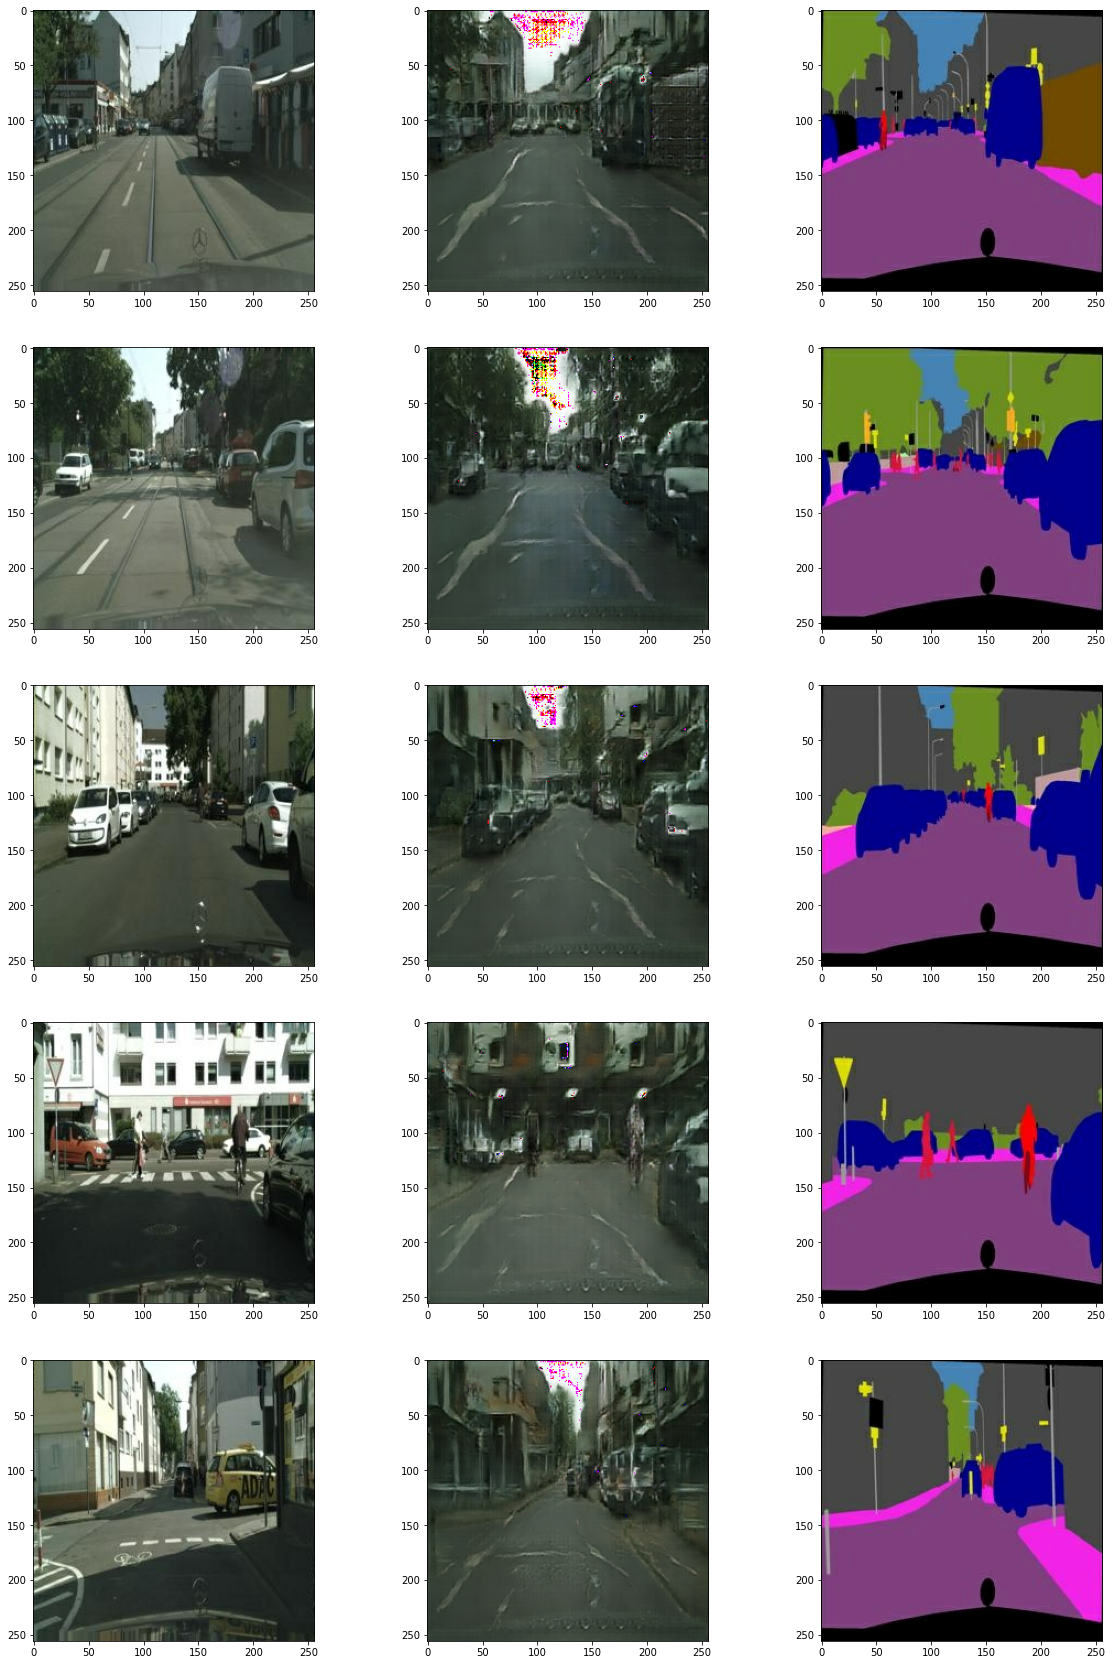

In [34]:
# test_ind = 1

plt.figure(figsize=(20,30))

for i in range(len(os.listdir(test_path))):

    f = test_path + os.listdir(test_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.subplot(5,3,3*i+1); plt.imshow(denormalize(colored))
    plt.subplot(5,3,3*i+2); plt.imshow(pred[0])
    plt.subplot(5,3,3*i+3); plt.imshow(denormalize(sketch))

<br>

### Loss 그래프 시각화

NameError: ignored

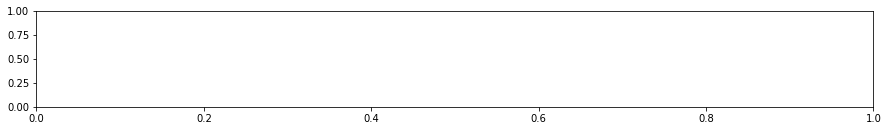

In [2]:
from matplotlib.pylab import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

# summarize Generator_loss
plt.subplot(311)  
plt.plot(Generator_loss)  
plt.title('Generator_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
# plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

# summarize L1_loss
plt.subplot(312)  
plt.plot(L1_loss)  
plt.title('L1_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
# plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  


# summarize Discriminator_loss
plt.subplot(313)  
plt.plot(Discriminator_loss)  
plt.title('Discriminator_loss')  
plt.ylabel('loss')  
plt.xlabel('batch iters')  
# plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  


## 결론
---

- 프로젝트 : Segmentation map으로 도로 이미지 만들기에서는 `pix2pix` 를 제안한  Image-to-Image Translation with Conditional Adversarial Networks에서 소개한 방법을 사용하여 진행하였다. 이 기법을 사용하면 **이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있게된다.**


- 데이터는 1000개의 train데이터와 4개의 validation 데이터로 분류되었으며 앞선 노드의 내용과 동일한 방법으로 데이터를 불러올 수 있었다.


- Generator 모델은 U-Net을 적용하였으며, Discriminator에서도 70x70 PatchGAN을 사용하였다.


- 학습양은 총 128 epochs를 수행하였다.<br>sketch / predict / color 형태로 수행 결과를 확인할 수 있다.


- 학습을 다 돌리고 나니 모든 history가 날라가 버렸다.... Loss 그래프 시각화를 다시 돌리려면 6시간 이상 돌려야 했기 때문에 ... 그리지 못했다.